In [146]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2

In [147]:
junk_thresh = 0.03

marked_image_directory = "full_data/"
clean_image_directory = "cropped_images/"

#marked_image_directory = "mid_data/"
#clean_image_directory = "good_crops/"

# Change this line to switch between marked and clean images for step 4.
directory = marked_image_directory

#svm_data_file = "SVM_mid_data.csv"
svm_data_file = "SVM_full_data.csv"
forest_data_file = "Forest_full_data.csv"
#forest_data_file = "Forest_mid_data.csv"
svm_df = pd.read_csv(svm_data_file)
svm_df = svm_df[:9086]
svm_df.drop(svm_df[svm_df["LeftoverInk"] > junk_thresh].index, inplace=True)
forest_df = pd.read_csv(forest_data_file)
print(len(forest_df))
forest_df = forest_df[:9086]
forest_df.drop(forest_df[forest_df["LeftoverInk"] > junk_thresh].index, inplace=True)
og_forest = forest_df
print(len(forest_df))
split_point = int(len(forest_df) * .8)
forest_df = forest_df[split_point:]

split_point = int(len(svm_df) * .8)
svm_df = svm_df[split_point:]

print(len(forest_df))

9134
6830
1366


In [148]:
# Helper function for applying a threshold to prediction values
def apply_single_threshold(predictions, threshold):
    threshed = []
    for prediction in predictions:
        if prediction >= threshold:
            threshed.append(1)
        else:
            threshed.append(0)

    return threshed

# 1. Histograms of Total Predicted Values

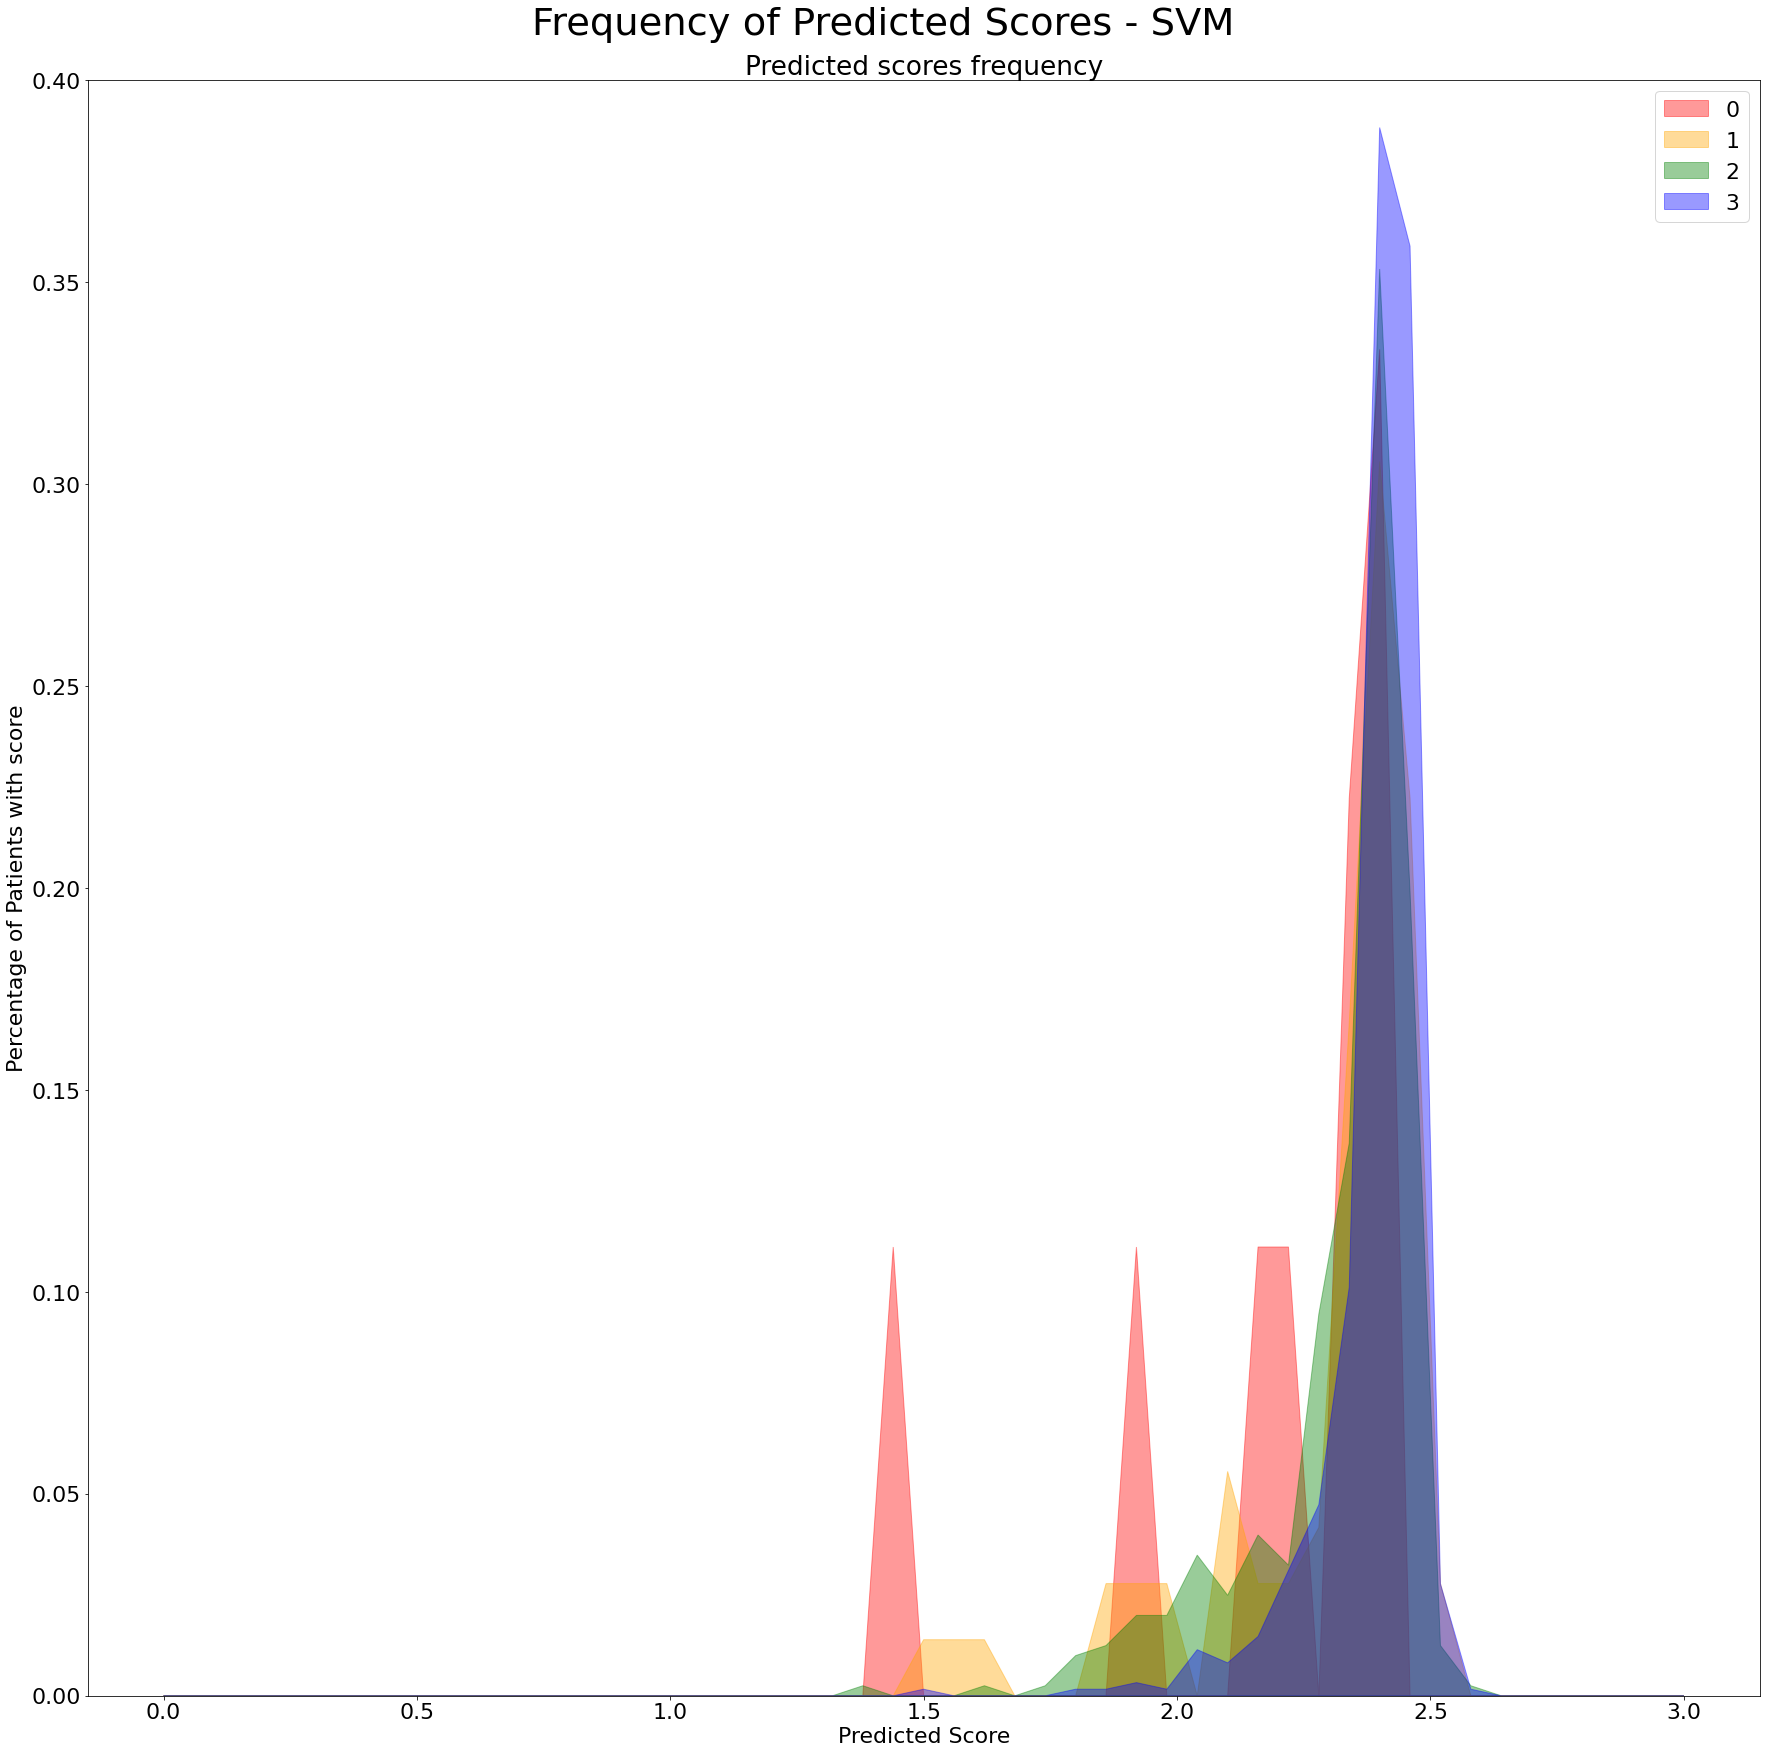

Number of Patients with Score 0: 9
Number of Patients with Score 1: 72
Number of Patients with Score 2: 402
Number of Patients with Score 3: 613


In [149]:
df = svm_df
df["Total"] = df["ClockContour"] + df["ClockHands"] + df["ClockNumbers"]
df["Pred_Total"] = df["SVM_Contour_F"] + df["SVM_Hands_Acc"] + df["SVM_Digits_Acc"]
fig = plt.figure(1, (25, 25))

colors = ["red", "orange", "green", "blue"]
scores = [0, 1, 2, 3]

plot_weights = []
plot_scores = []
for i, score in enumerate(scores):
    
    relevant_scores = df[df["Total"] == score]
    predicted_scores = np.array(relevant_scores["Pred_Total"])
    plot_scores.append(predicted_scores)

    weights = np.ones_like(predicted_scores)/float(len(predicted_scores))
    plot_weights.append(weights)
    #plt.subplot(2, 2, score+1)
n, bins, _ = plt.hist(plot_scores, bins=50, histtype="step", label=scores, fill=True, stacked=False,
         weights=plot_weights, density=False, color=colors, range=[0, 3.0], linewidth=5, alpha=0.4)

# Comment this to return to normal histogram
plt.clf()
for i in range(len(n)):
    predicts = list(n[i])
    predicts.append(0)
    plt.fill(bins, predicts, label=i, alpha=0.4, color=colors[i])
    
plt.rcParams.update({'font.size': 32})
plt.suptitle("Frequency of Predicted Scores - SVM")
plt.rcParams.update({'font.size': 22})

plt.xlabel("Predicted Score")
#plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=[0, 1, 2, 3])
plt.ylabel("Percentage of Patients with score")
plt.title("Predicted scores frequency")
plt.ylim(0, 0.4)
plt.legend()
plt.show()

for score in [0, 1, 2, 3]:
    relevant_scores = df[df["Total"] == score]
    print("Number of Patients with Score " + str(score) + ": " + str(len(relevant_scores)))
                 

c:\users\dh33\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\dh33\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


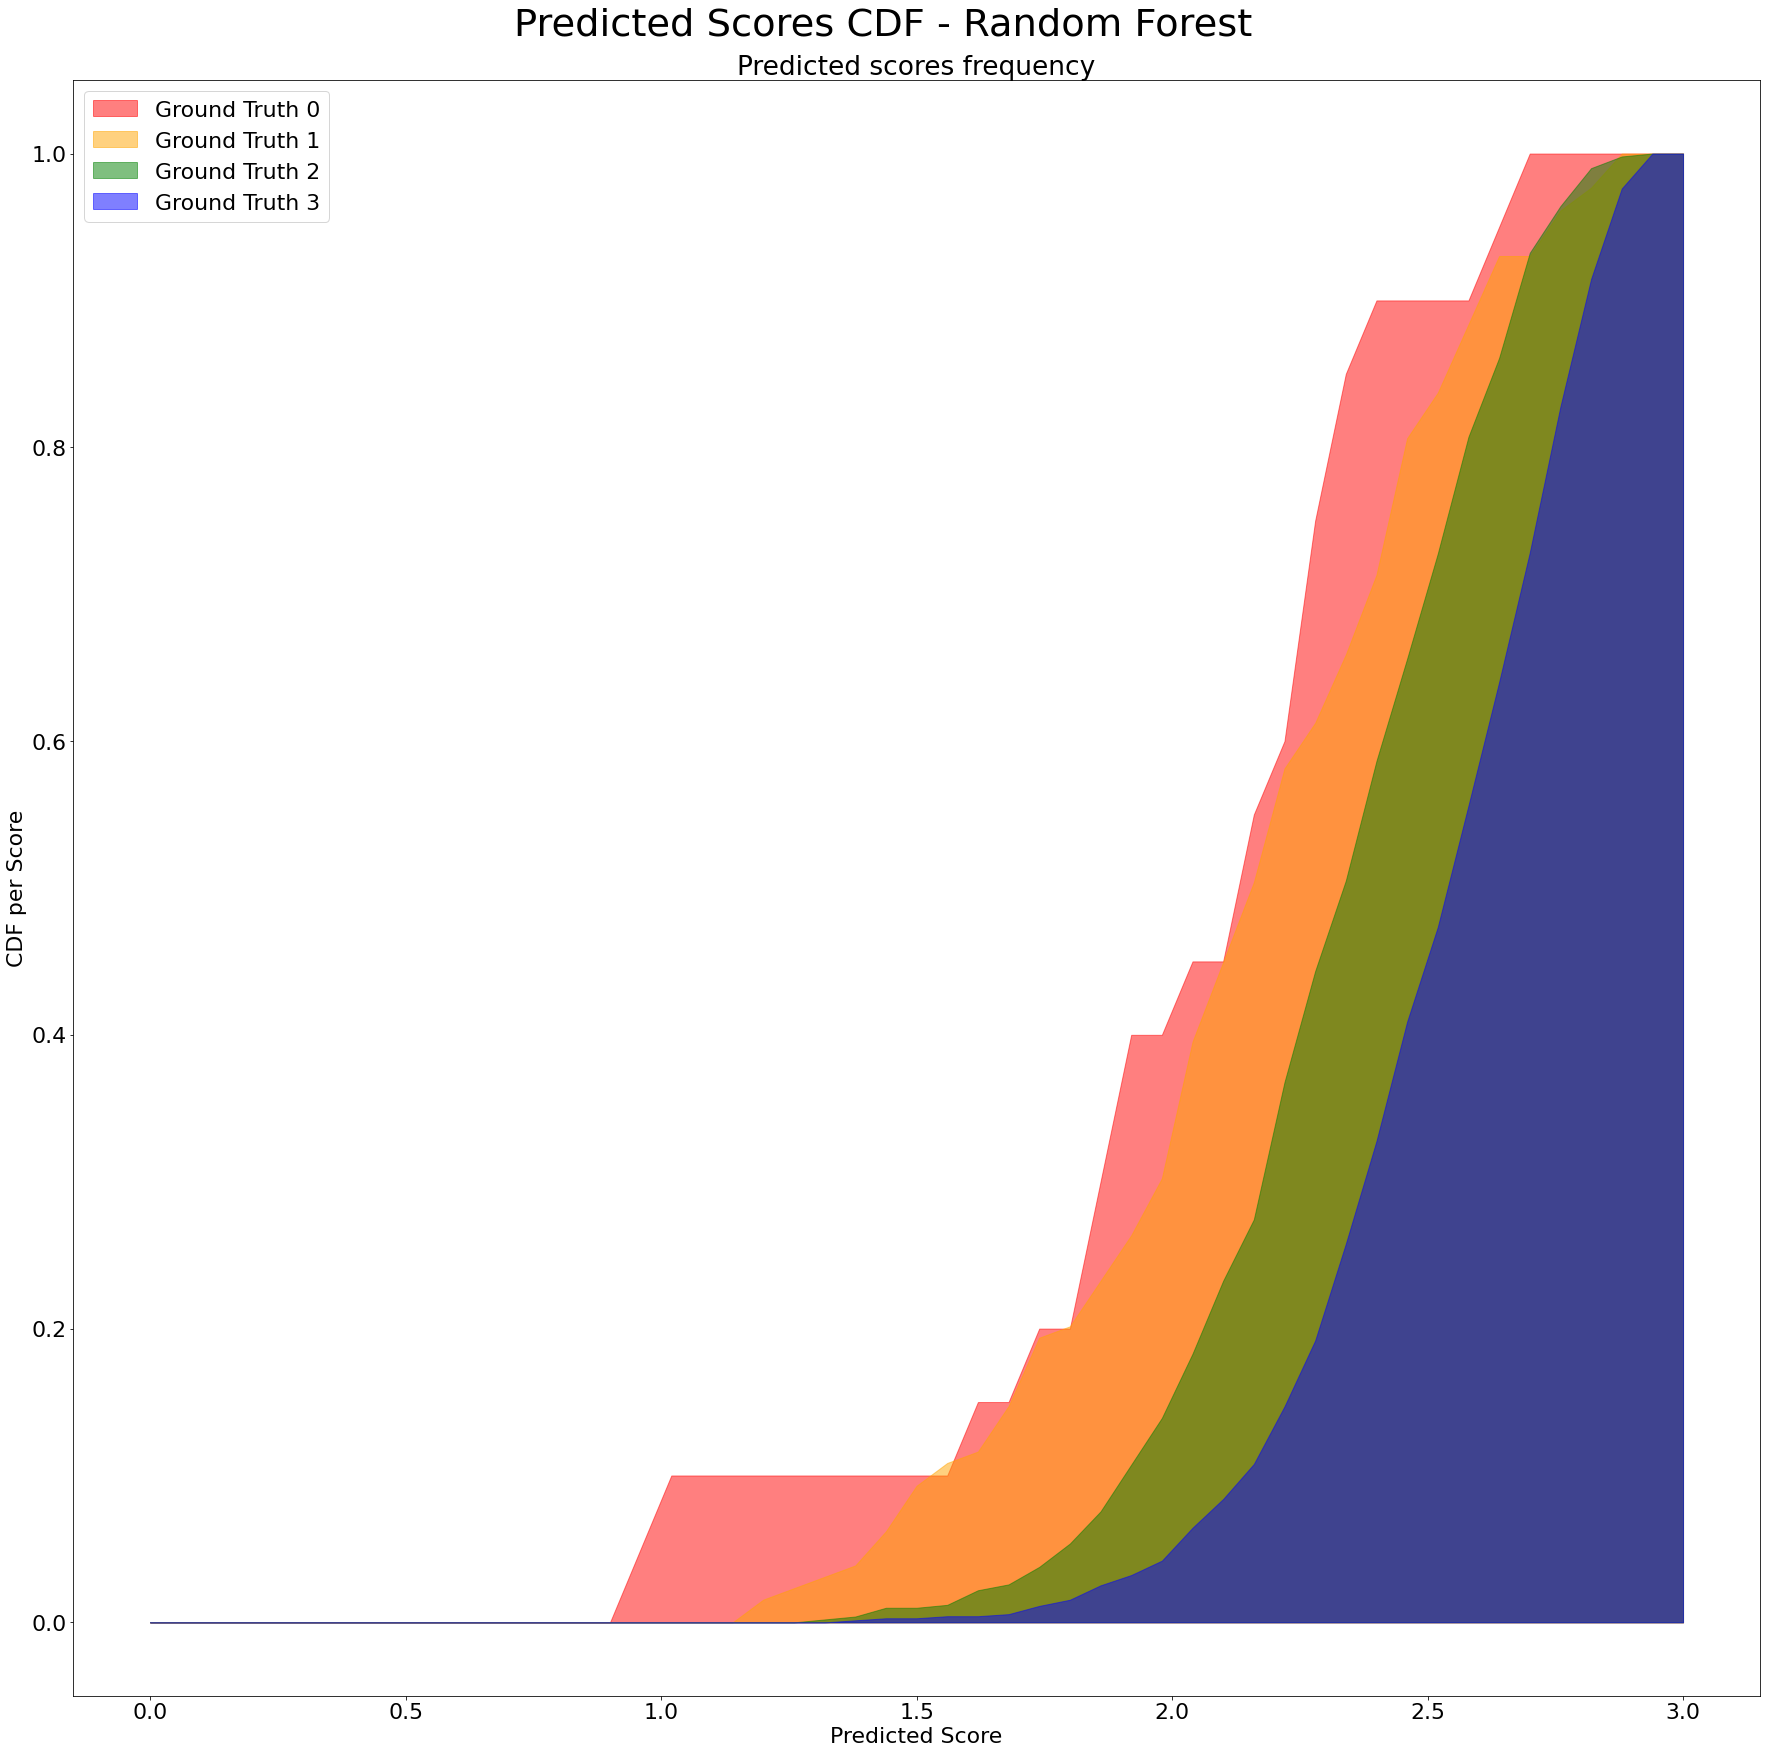

Number of Patients with Score 0: 20
Number of Patients with Score 1: 129
Number of Patients with Score 2: 503
Number of Patients with Score 3: 714


In [150]:
df = forest_df
df["Total"] = df["ClockContour"] + df["ClockHands"] + df["ClockNumbers"]
df["Pred_Total"] = df["Forest_Contour"] + df["Forest_Hands"] + df["Forest_Digits"]
fig = plt.figure(1, (25, 25))

colors = ["red", "orange", "green", "blue"]
scores = [0, 1, 2, 3]

plot_weights = []
plot_scores = []
for score in scores:
    
    relevant_scores = df[df["Total"] == score]
    predicted_scores = np.array(relevant_scores["Pred_Total"])
    plot_scores.append(predicted_scores)

    weights = np.ones_like(predicted_scores)/float(len(predicted_scores))
    plot_weights.append(weights)
    #plt.subplot(2, 2, score+1)
n, bins, _ = plt.hist(plot_scores, bins=50, histtype="step", label=scores, fill=True, stacked=False,
         weights=plot_weights, density=False, color=colors, range=[0, 3.0], linewidth=5, alpha=0.4)

# Comment this to return to normal histogram
plt.clf()
for i in range(len(n)):
    predicts = list(n[i])
    predicts.append(0)
    plt.fill_between(bins, np.cumsum(predicts), label="Ground Truth " + str(i), alpha=0.5, color=colors[i])

plt.rcParams.update({'font.size': 32})
plt.suptitle("Predicted Scores CDF - Random Forest")
plt.rcParams.update({'font.size': 22})
    
plt.xlabel("Predicted Score")
#plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=[0, 1, 2, 3])
plt.ylabel("CDF per Score")
plt.title("Predicted scores frequency")
#plt.ylim(0, 0.2)
plt.legend(loc="upper left")
plt.savefig("results/total_cdf.jpg")
plt.show()

for score in [0, 1, 2, 3]:
    relevant_scores = df[df["Total"] == score]
    print("Number of Patients with Score " + str(score) + ": " + str(len(relevant_scores)))

6863
6863


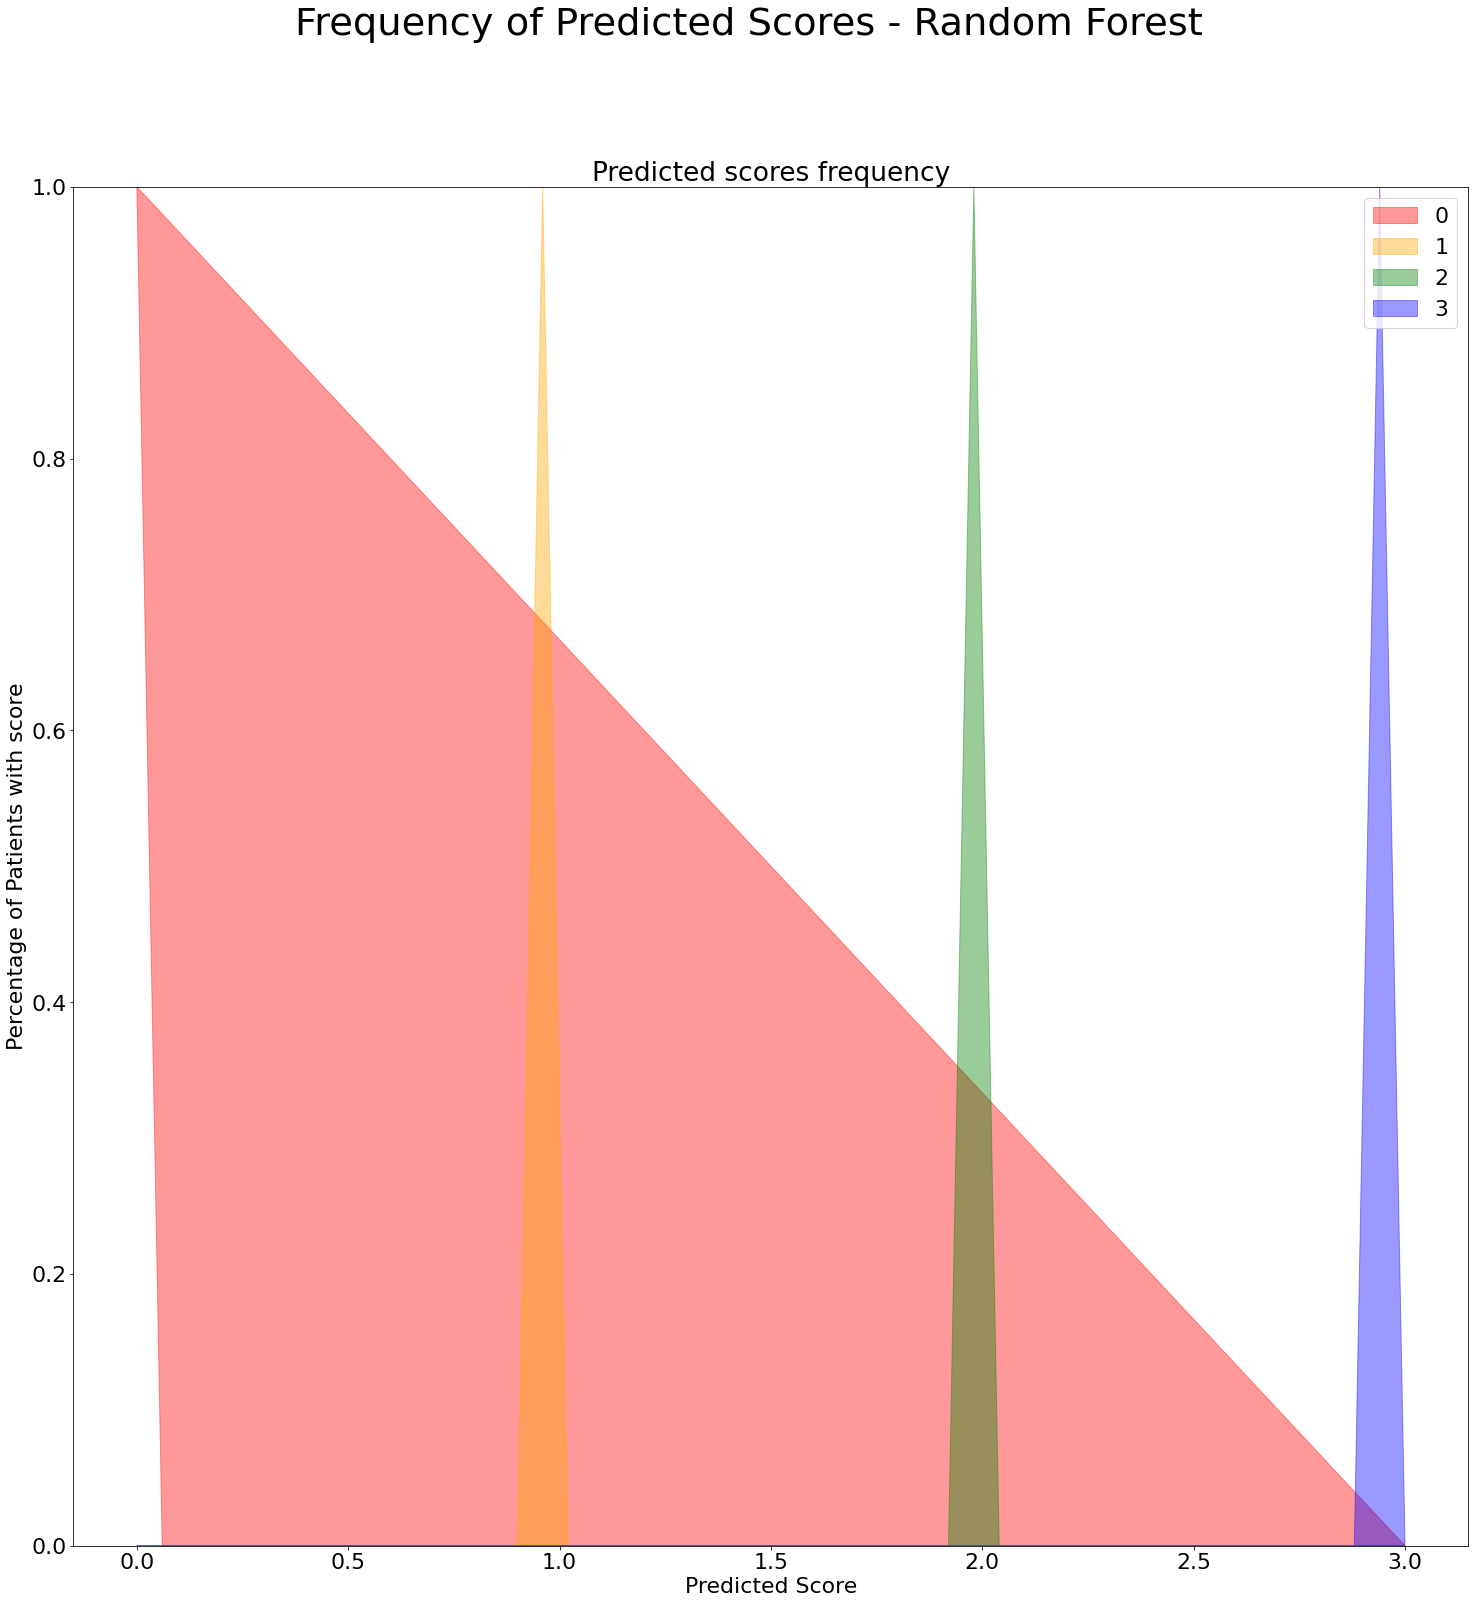

Number of Patients with Score 0: 20
Number of Patients with Score 1: 132
Number of Patients with Score 2: 505
Number of Patients with Score 3: 716


In [18]:
forest_data_file = "forest_MoCA.csv"
#forest_data_file = "Forest_mid_data.csv"
svm_df = pd.read_csv(svm_data_file)
svm_df = svm_df[:9086]
svm_df.drop(svm_df[svm_df["LeftoverInk"] > junk_thresh].index, inplace=True)
forest_df = pd.read_csv(forest_data_file)
print(len(forest_df))
forest_df = forest_df[:9086]
forest_df.drop(forest_df[forest_df["LeftoverInk"] > junk_thresh].index, inplace=True)
print(len(forest_df))
split_point = int(len(forest_df) * .8)
forest_df = forest_df[split_point:]
df = forest_df

df["Total"] = df["ClockContour"] + df["ClockHands"] + df["ClockNumbers"]
fig = plt.figure(1, (25, 25))

colors = ["red", "orange", "green", "blue"]
scores = [0, 1, 2, 3]

plot_weights = []
plot_scores = []
for score in scores:
    
    relevant_scores = df[df["Total"] == score]
    predicted_scores = np.array(relevant_scores["Forest_Total"])
    plot_scores.append(predicted_scores)

    weights = np.ones_like(predicted_scores)/float(len(predicted_scores))
    plot_weights.append(weights)
    #plt.subplot(2, 2, score+1)
n, bins, _ = plt.hist(plot_scores, bins=50, histtype="step", label=scores, fill=True, stacked=False,
         weights=plot_weights, density=False, color=colors, range=[0, 3.0], linewidth=5, alpha=0.4)

# Comment this to return to normal histogram
plt.clf()
for i in range(len(n)):
    predicts = list(n[i])
    predicts.append(0)
    plt.fill(bins, predicts, label=i, alpha=0.4, color=colors[i])

plt.rcParams.update({'font.size': 32})
plt.suptitle("Frequency of Predicted Scores - Random Forest")
plt.rcParams.update({'font.size': 22})
    
plt.xlabel("Predicted Score")
#plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=[0, 1, 2, 3])
plt.ylabel("Percentage of Patients with score")
plt.title("Predicted scores frequency")
plt.ylim(0, 1)
plt.legend()
plt.show()

for score in [0, 1, 2, 3]:
    relevant_scores = df[df["Total"] == score]
    print("Number of Patients with Score " + str(score) + ": " + str(len(relevant_scores)))

# 2.1 Histograms of Category Predicted Values - SVM

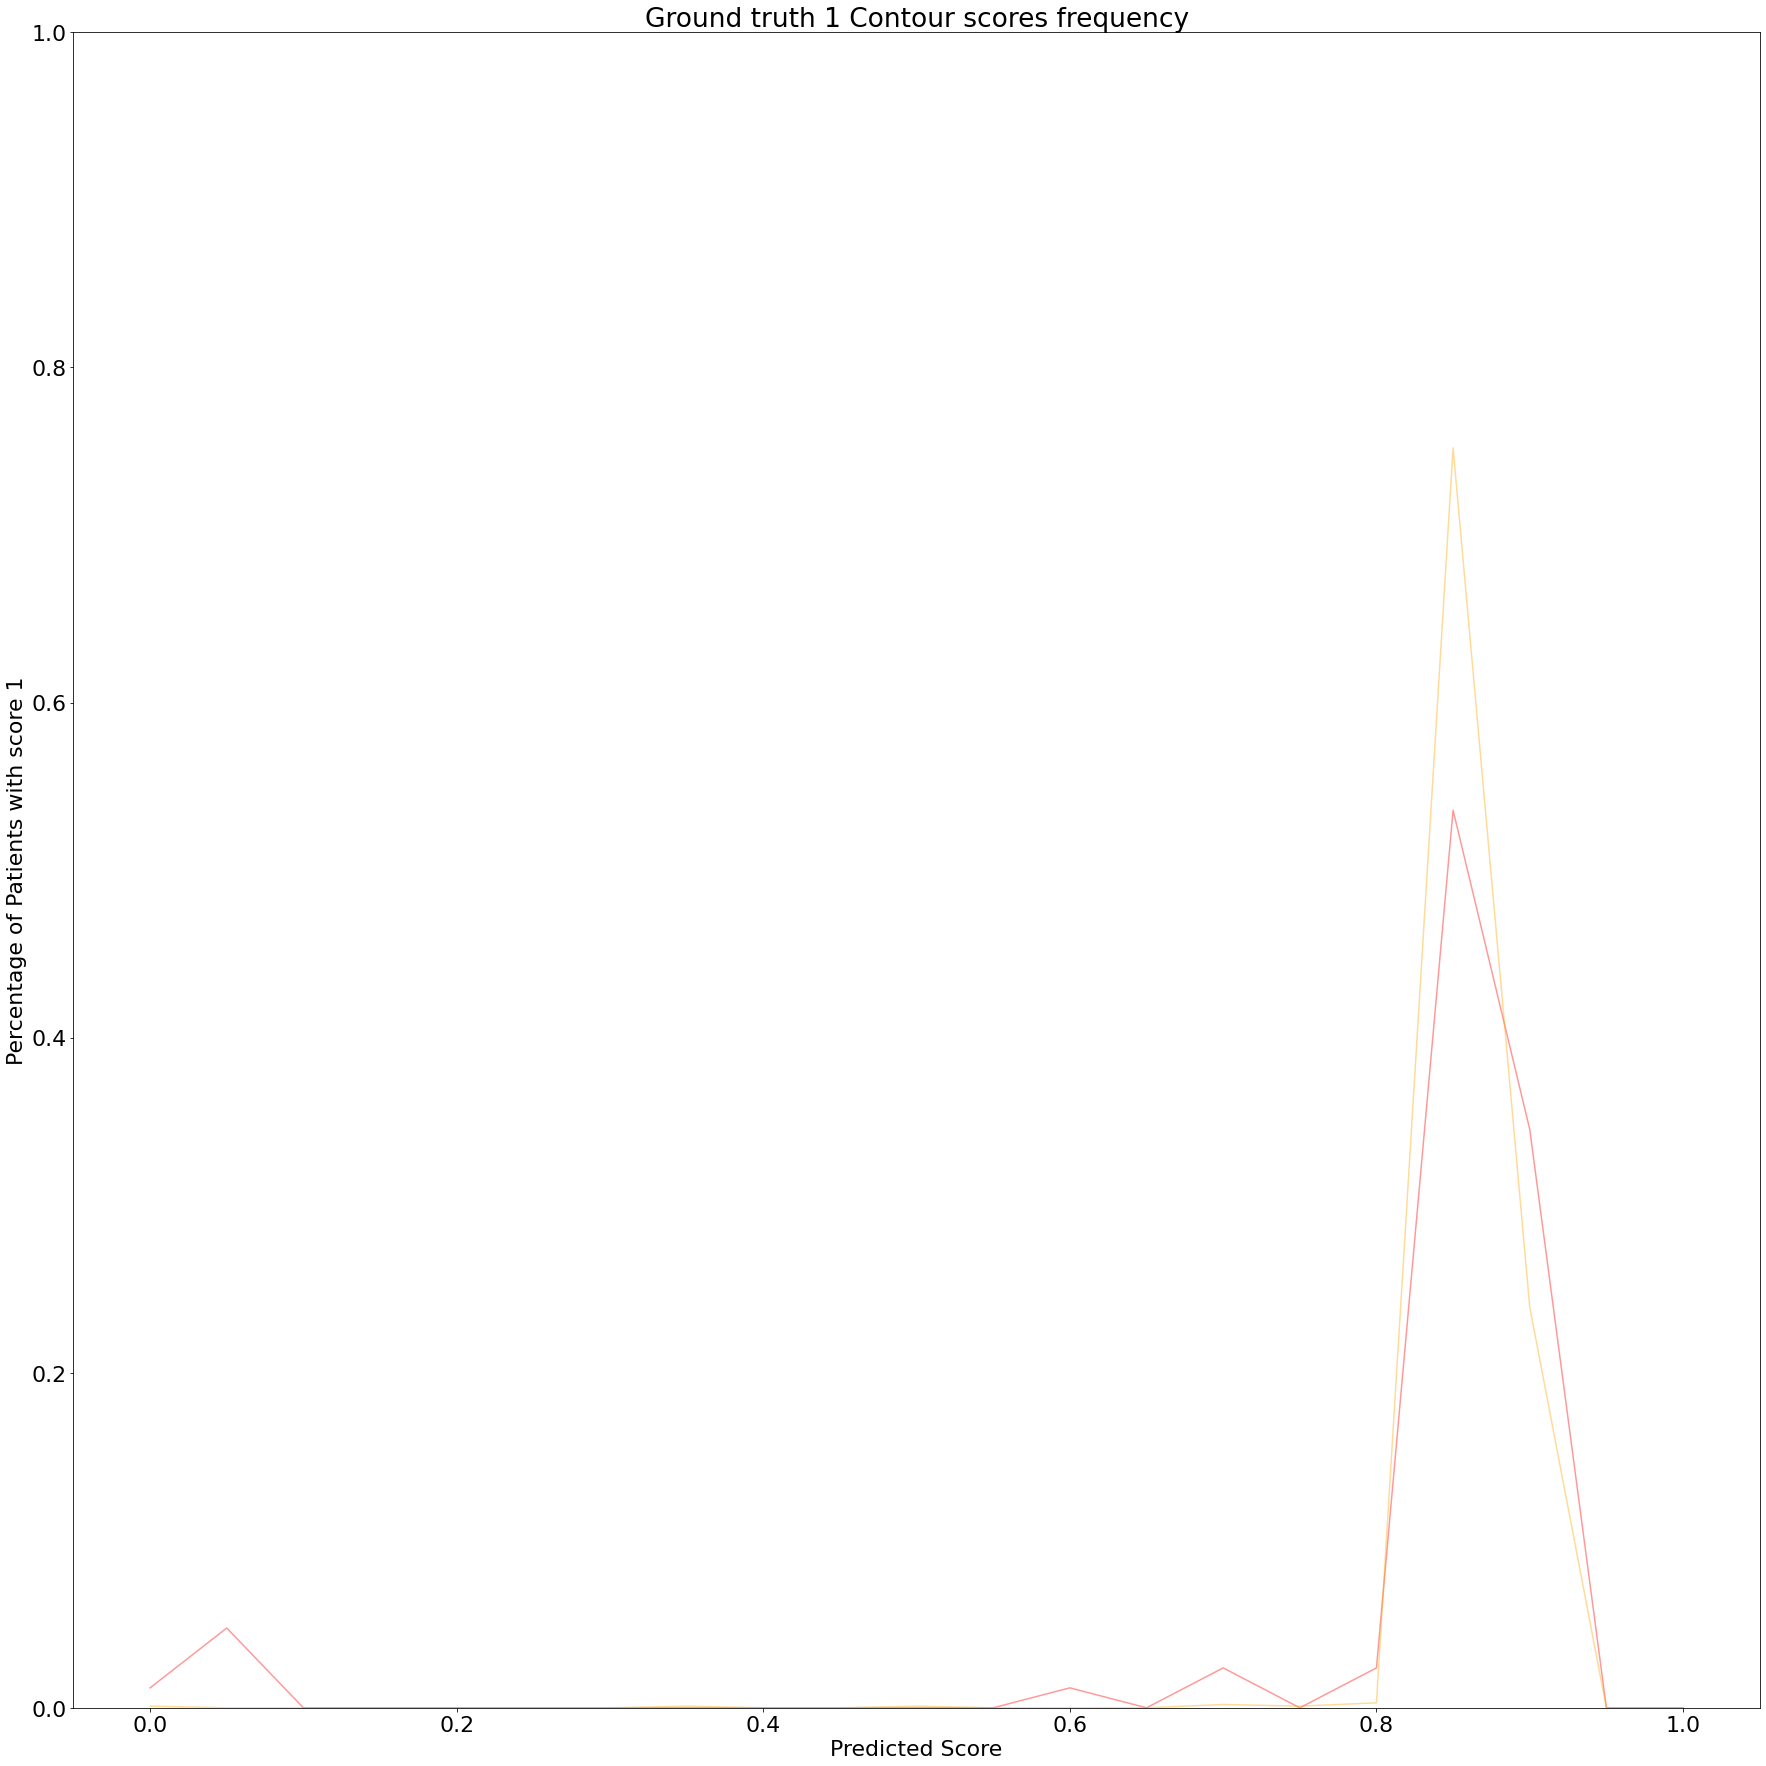

Number of Patients with Contour Score 0: 84
Number of Patients with Contour Score 1: 1012

Number of Patients with Hands Score 0: 395
Number of Patients with Hands Score 1: 701

Number of Patients with Digits Score 0: 94
Number of Patients with Digits Score 1: 1002



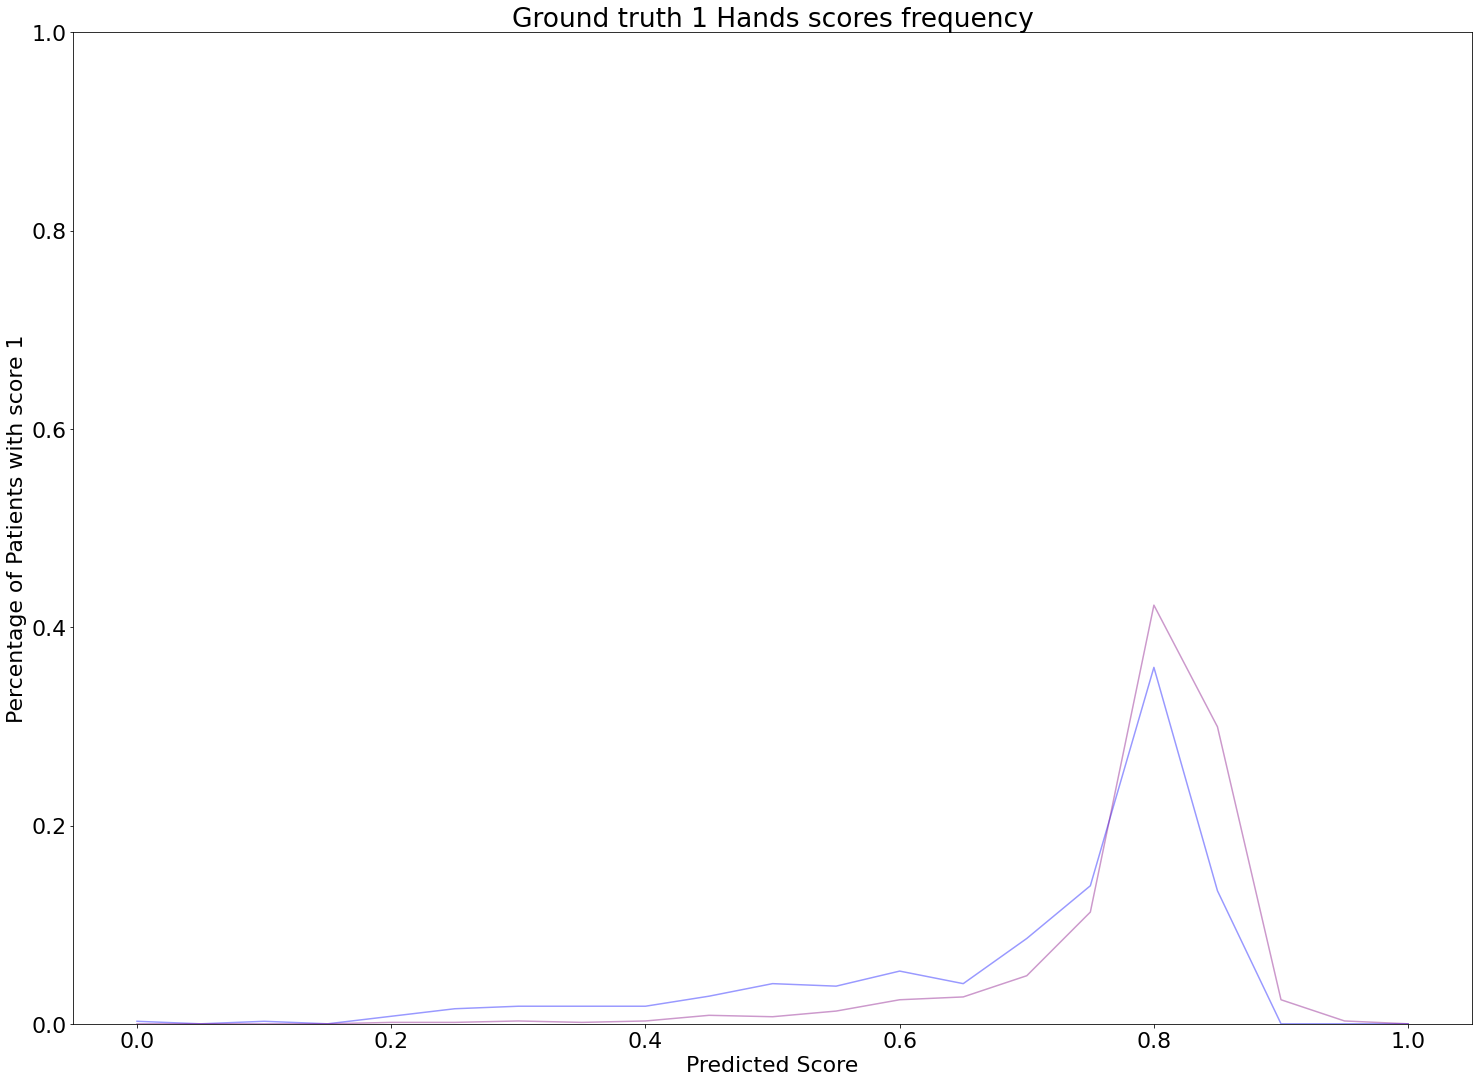

Number of Patients with Contour Score 0: 84
Number of Patients with Contour Score 1: 1012

Number of Patients with Hands Score 0: 395
Number of Patients with Hands Score 1: 701

Number of Patients with Digits Score 0: 94
Number of Patients with Digits Score 1: 1002



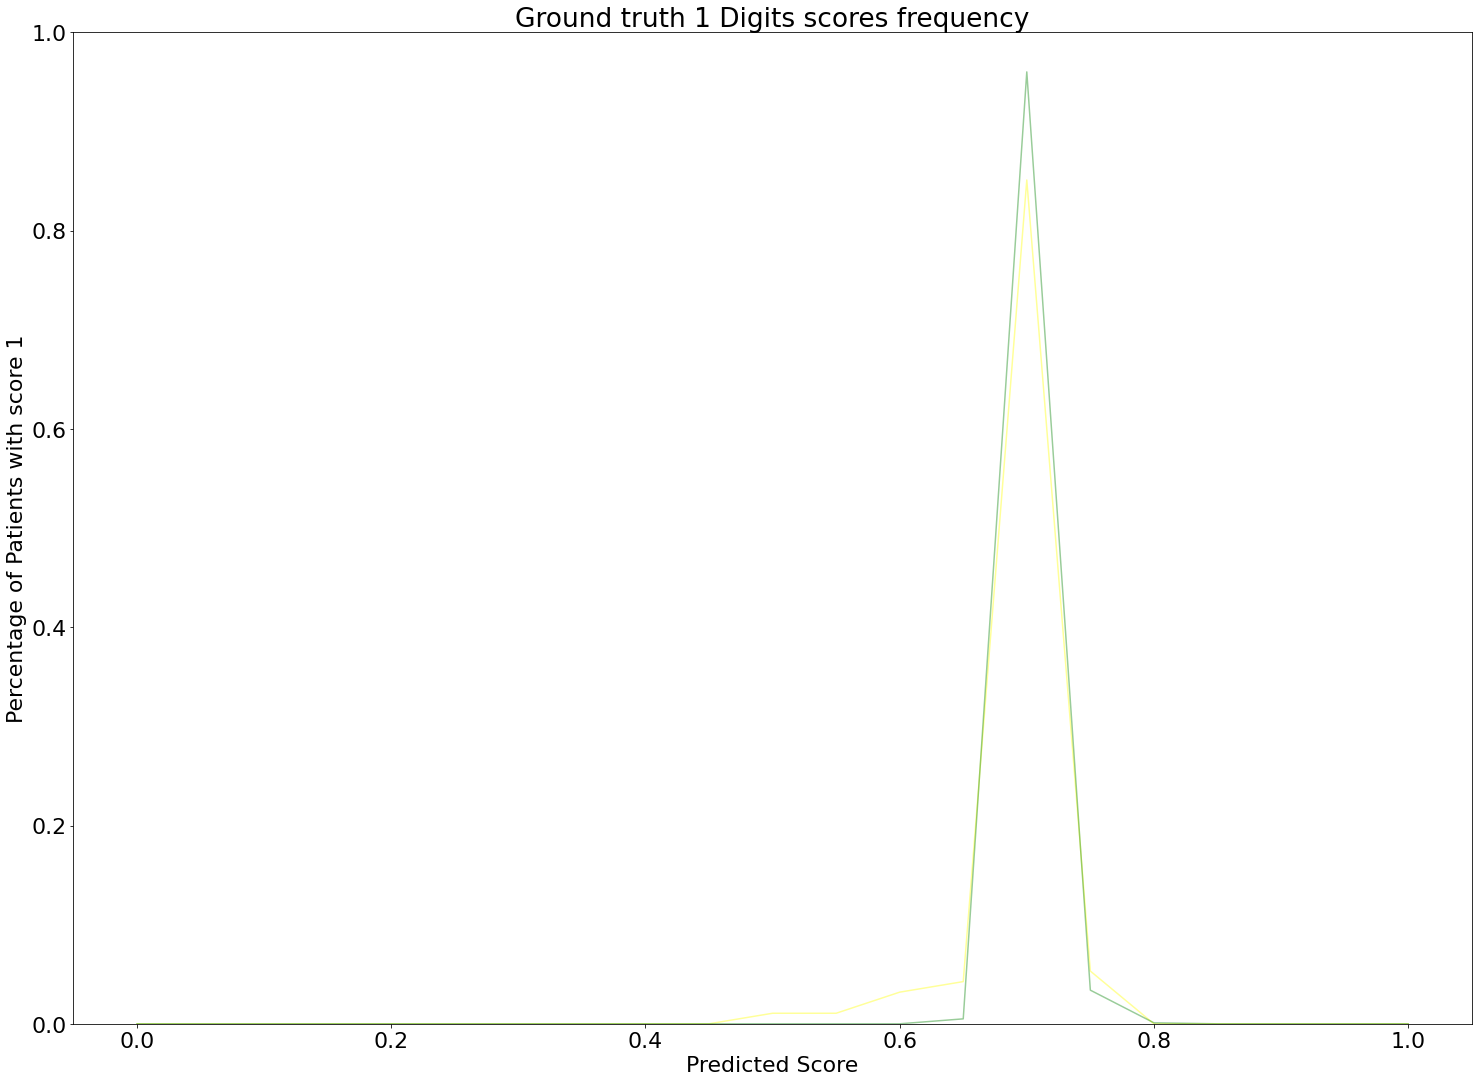

Number of Patients with Contour Score 0: 84
Number of Patients with Contour Score 1: 1012

Number of Patients with Hands Score 0: 395
Number of Patients with Hands Score 1: 701

Number of Patients with Digits Score 0: 94
Number of Patients with Digits Score 1: 1002



In [49]:
df = svm_df
df["Total"] = df["ClockContour"] + df["ClockHands"] + df["ClockNumbers"]
fig = plt.figure(1, (25, 25))

plt.rcParams.update({'font.size': 32})
plt.suptitle("Frequency of Predicted Scores across Categories")
plt.rcParams.update({'font.size': 22})

colors = [["red", "orange"], ["blue", "purple"], ["yellow", "green"]]
names = ["Contour", "Hands", "Digits"]
predictions = ["SVM_Contour_F", "SVM_Hands_Acc", "SVM_Digits_Acc"]

# We can set the number of bins with the `bins` kwarg
for i, category in enumerate(["ClockContour", "ClockHands", "ClockNumbers"]):
    predicted_scores = []
    plot_weights = []
    for score in [0, 1]:

        relevant_scores = df[df[category] == score]
        scores = np.array(relevant_scores[predictions[i]])
        predicted_scores.append(scores)

        weights = np.ones_like(scores)/float(len(scores))
        plot_weights.append(weights)

    n, bins, patches = plt.hist(predicted_scores, bins=20, weights=plot_weights, edgecolor="black", density=False, color=colors[i], range=[0, 1])

    plt.subplot(3, 1, i+1)
    # Comment this to return to normal histogram
    plt.clf()
    for j in range(len(n)):
        predicts = list(n[j])
        predicts.append(0)
        plt.plot(bins, predicts, label=i, alpha=0.4, color=colors[i][j])

    plt.xlabel("Predicted Score")
    #plt.xticks(ticks=[0.5, 1.5], labels=[0, 1])
    plt.ylabel("Percentage of Patients with score " + (str(score)))
    plt.title("Ground truth " + str(score) + " " + names[i] + " scores frequency")
    plt.ylim(0, 1)
    plt.show()

    for i, category in enumerate(["ClockContour", "ClockHands", "ClockNumbers"]):
        for score in [0, 1]:
            relevant_scores = df[df[category] == score]
            print("Number of Patients with " + str(names[i]) + " Score " + str(score) + ": " + str(len(relevant_scores)))
        print("")

# 2.2 Histograms of Category Predicted Values - Random Forest

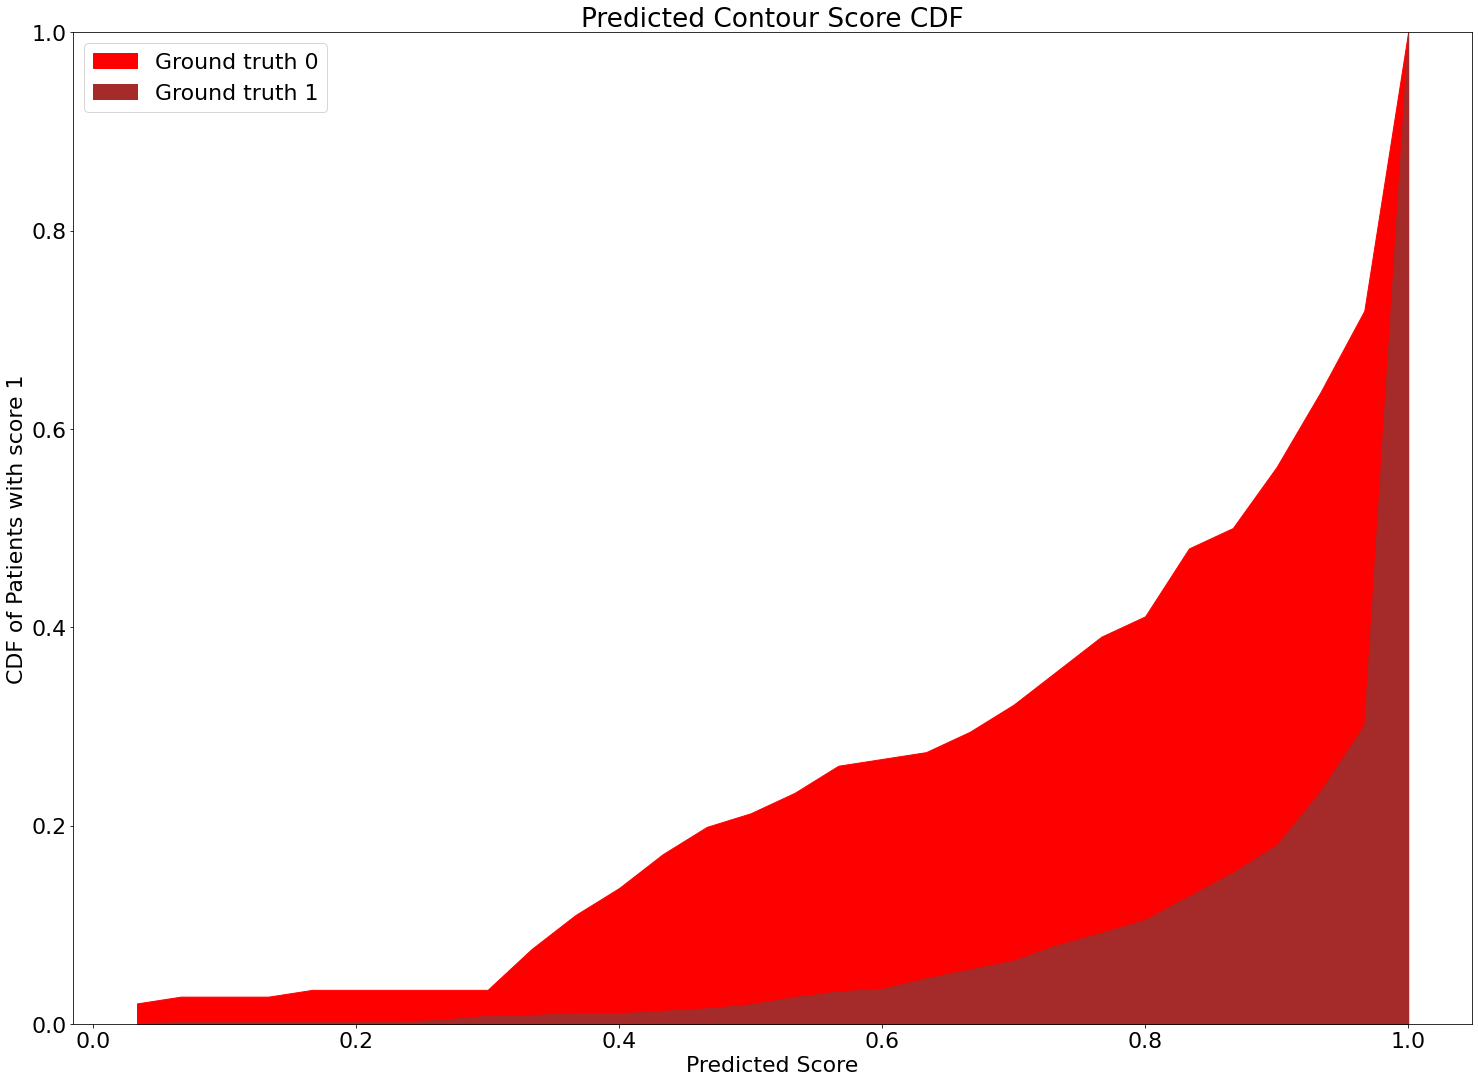

Number of Patients with Contour Score 0: 146
Number of Patients with Contour Score 1: 1220

Number of Patients with Hands Score 0: 541
Number of Patients with Hands Score 1: 825

Number of Patients with Digits Score 0: 134
Number of Patients with Digits Score 1: 1232



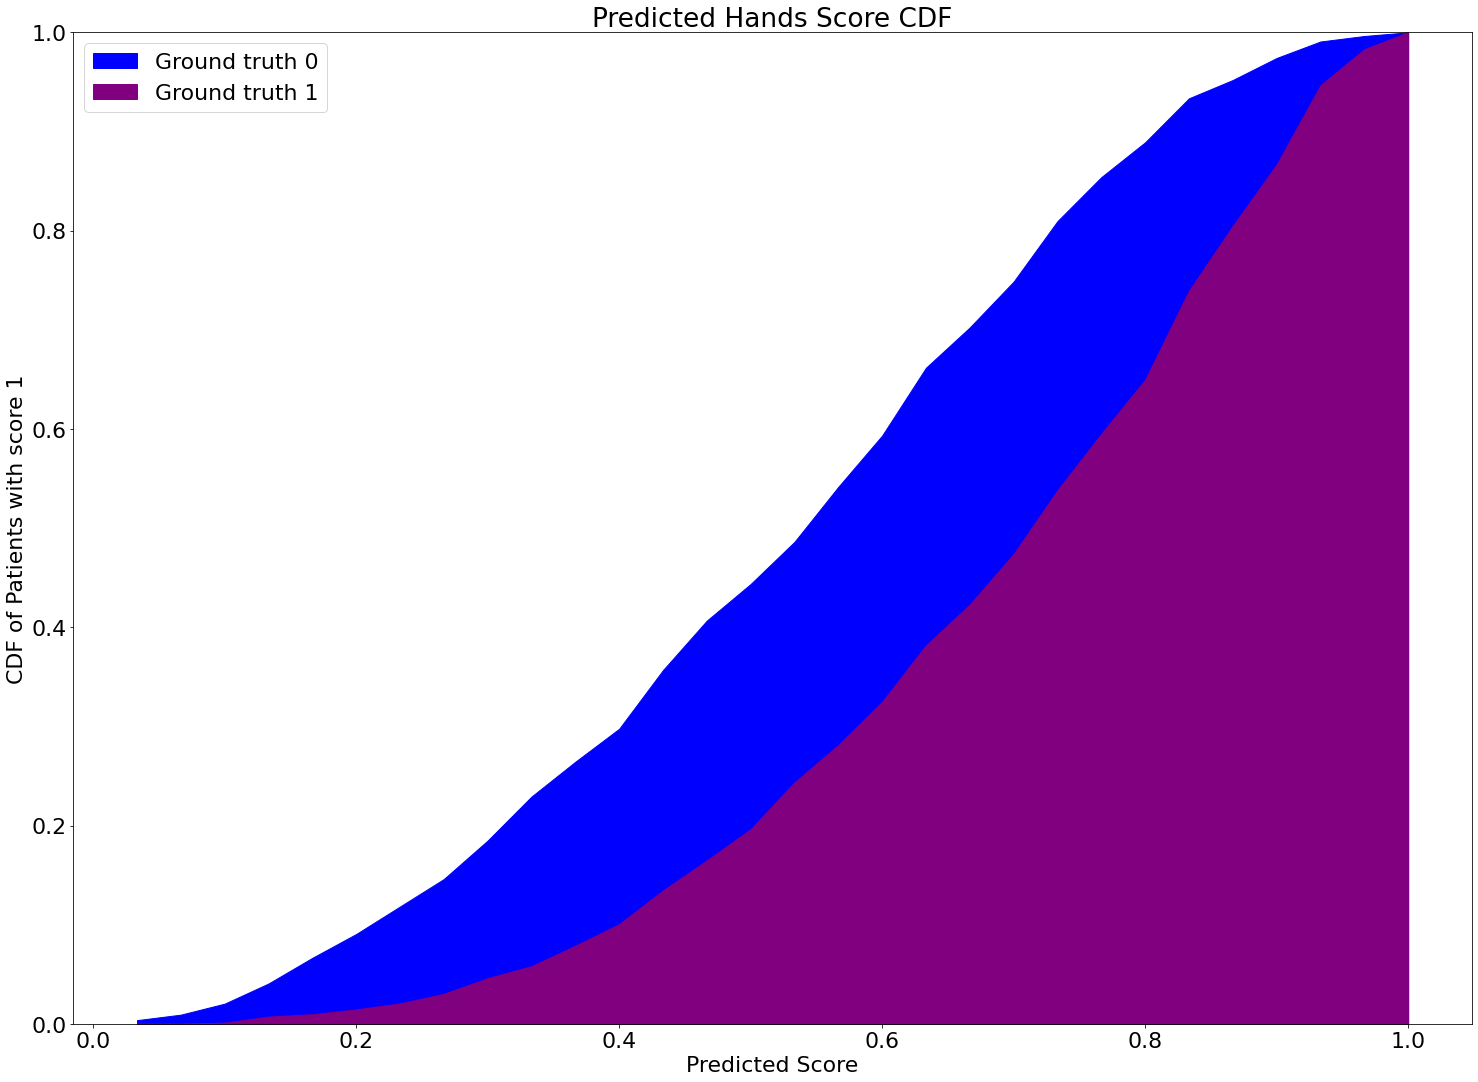

Number of Patients with Contour Score 0: 146
Number of Patients with Contour Score 1: 1220

Number of Patients with Hands Score 0: 541
Number of Patients with Hands Score 1: 825

Number of Patients with Digits Score 0: 134
Number of Patients with Digits Score 1: 1232



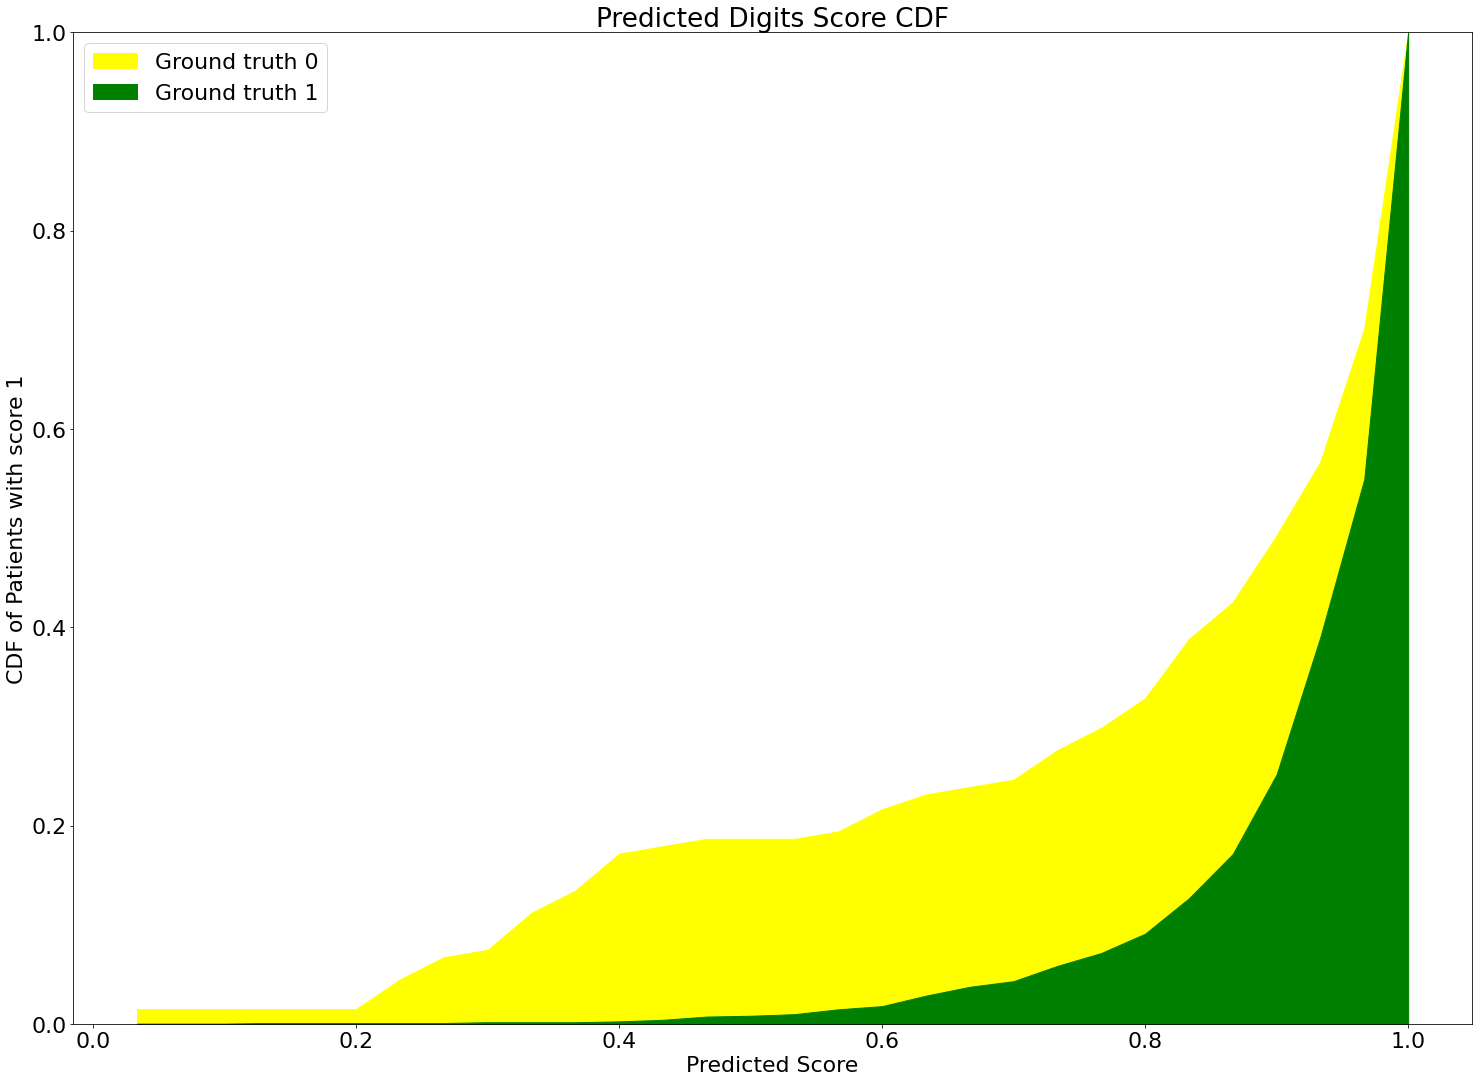

Number of Patients with Contour Score 0: 146
Number of Patients with Contour Score 1: 1220

Number of Patients with Hands Score 0: 541
Number of Patients with Hands Score 1: 825

Number of Patients with Digits Score 0: 134
Number of Patients with Digits Score 1: 1232



In [109]:
df = forest_df
df["Total"] = df["ClockContour"] + df["ClockHands"] + df["ClockNumbers"]
#fig = plt.figure(1, (10, 7))

plt.rcParams.update({'font.size': 32})
plt.suptitle("Frequency of Predicted Scores across Categories")
plt.rcParams.update({'font.size': 22})

#colors = ["red", "blue", "yellow"]
colors = [["red", "brown"], ["blue", "purple"], ["yellow", "green"]]
names = ["Contour", "Hands", "Digits"]
predictions = ["Forest_Contour", "Forest_Hands", "Forest_Digits"]

# We can set the number of bins with the `bins` kwarg
# We can set the number of bins with the `bins` kwarg
for i, category in enumerate(["ClockContour", "ClockHands", "ClockNumbers"]):
    predicted_scores = []
    plot_weights = []
    for score in [0, 1]:

        relevant_scores = df[df[category] == score]
        scores = np.array(relevant_scores[predictions[i]])
        #print(np.max(scores))
        predicted_scores.append(scores)

        weights = np.ones_like(scores)/float(len(scores))
        plot_weights.append(weights)

    n, bins, patches = plt.hist(predicted_scores, bins=30, weights=plot_weights, edgecolor="black", density=False, color=colors[i], range=[0, 1])

    plt.subplot(3, 1, i+1)
    # Comment this to return to normal histogram
    plt.clf()
    for j in range(len(n)):
        predicts = list(n[j])
        predicts = list(np.cumsum(predicts))
        
        plt.fill_between(bins[1:], predicts, label="Ground truth " + str(j), alpha=1.0, color=colors[i][j])

    plt.xlabel("Predicted Score")
    #plt.xticks(ticks=[0.5, 1.5], labels=[0, 1])
    plt.ylabel("CDF of Patients with score " + (str(score)))
    plt.title("Predicted " + names[i] + " Score CDF")
    plt.ylim(0, 1)
    plt.legend(loc="upper left")
    plt.savefig(category + "_cdf.jpg")
    plt.show()

    for i, category in enumerate(["ClockContour", "ClockHands", "ClockNumbers"]):
        for score in [0, 1]:
            relevant_scores = df[df[category] == score]
            print("Number of Patients with " + str(names[i]) + " Score " + str(score) + ": " + str(len(relevant_scores)))
        print("")

# 3.1 Table of Prediction Values - SVM

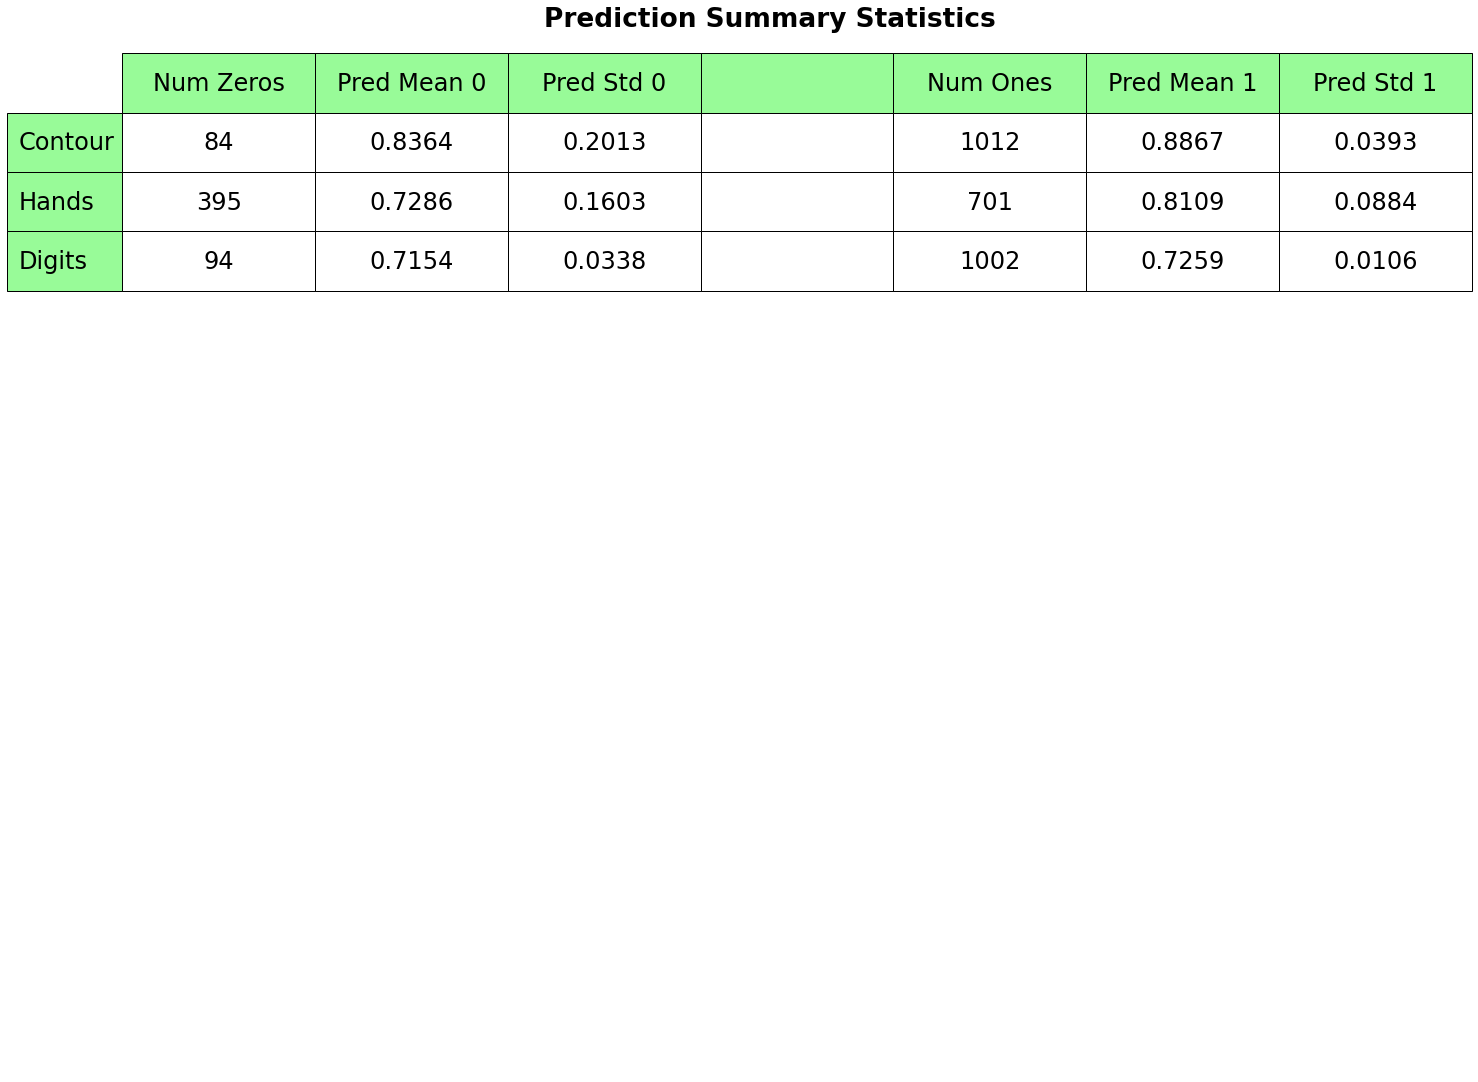

In [28]:
df = svm_df
table_lines = []

decimals = 4
header = ["Num Zeros", "Pred Mean 0", "Pred Std 0", "", "Num Ones", "Pred Mean 1", "Pred Std 1"]
names = ["Contour", "Hands", "Digits"]
truths = ["ClockContour", "ClockHands", "ClockNumbers"]
predictions = ["SVM_Contour_F", "SVM_Hands_Acc", "SVM_Digits_Acc"]
for i in range(len(truths)):
    zero_truths = df[df[truths[i]] == 0]
    zero_preds = np.array(zero_truths[predictions[i]])
    one_truths = df[df[truths[i]] == 1]
    one_preds = np.array(one_truths[predictions[i]])
    table_lines.append([len(zero_truths),
                        np.round(np.mean(zero_preds), decimals=decimals),
                        np.round(np.std(zero_preds), decimals=decimals),
                        "",
                        len(one_truths),
                        np.round(np.mean(one_preds), decimals=decimals),
                        np.round(np.std(one_preds), decimals=decimals)])
                       

plt.rcParams["figure.figsize"] = [21.00, 15.50]
plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots()
plt.rcParams.update({'font.size': 22})
ax.axis('tight')
ax.axis('off')
table = ax.table(
    cellText = table_lines,
    rowLabels = names,
    colLabels = header,
    rowColours =["palegreen"] * 10,
    colColours =["palegreen"] * 10, 
    cellLoc ='center',  
    loc ='upper left')

table.auto_set_font_size(False)
table.set_fontsize(24)
table.scale(1, 4)
ax.set_title('Prediction Summary Statistics', 
             fontweight ="bold")
plt.show()

# 3.2 Table of Prediction Values - Random Forest

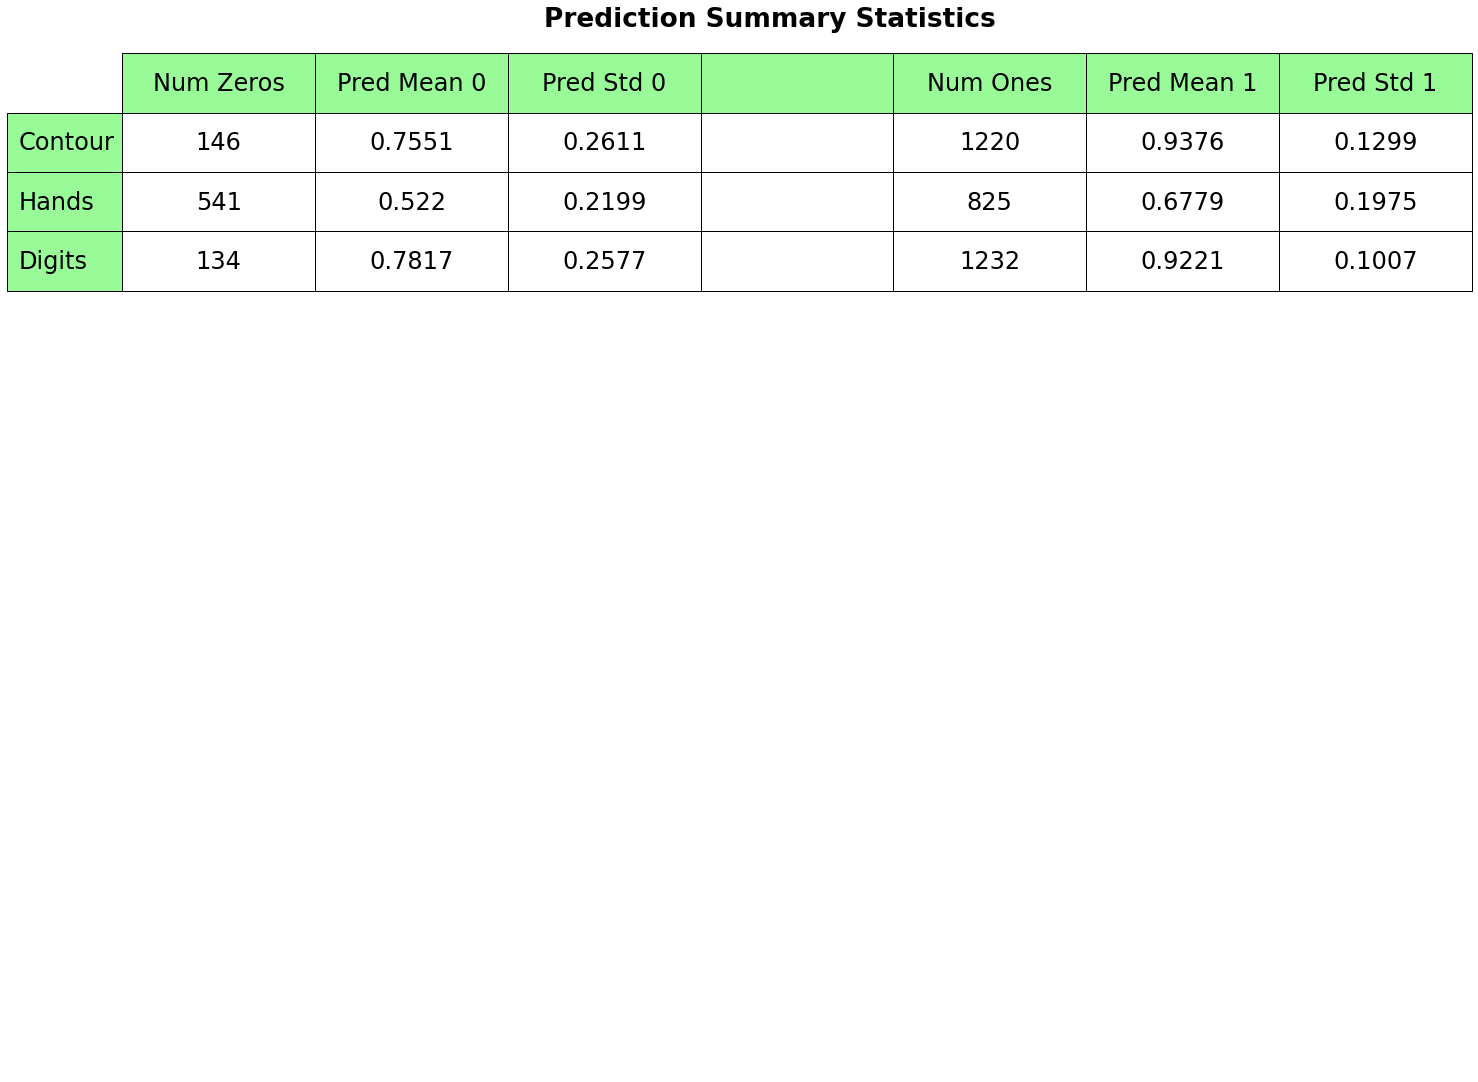

In [29]:
df = forest_df
table_lines = []

decimals = 4
header = ["Num Zeros", "Pred Mean 0", "Pred Std 0", "", "Num Ones", "Pred Mean 1", "Pred Std 1"]
names = ["Contour", "Hands", "Digits"]
truths = ["ClockContour", "ClockHands", "ClockNumbers"]
predictions = ["Forest_Contour", "Forest_Hands", "Forest_Digits"]
for i in range(len(truths)):
    zero_truths = df[df[truths[i]] == 0]
    zero_preds = np.array(zero_truths[predictions[i]])
    one_truths = df[df[truths[i]] == 1]
    one_preds = np.array(one_truths[predictions[i]])
    table_lines.append([len(zero_truths),
                        np.round(np.mean(zero_preds), decimals=decimals),
                        np.round(np.std(zero_preds), decimals=decimals),
                        "",
                        len(one_truths),
                        np.round(np.mean(one_preds), decimals=decimals),
                        np.round(np.std(one_preds), decimals=decimals)])
                       

plt.rcParams["figure.figsize"] = [21.00, 15.50]
plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots()
plt.rcParams.update({'font.size': 22})
ax.axis('tight')
ax.axis('off')
table = ax.table(
    cellText = table_lines,
    rowLabels = names,
    colLabels = header,
    rowColours =["palegreen"] * 10,
    colColours =["palegreen"] * 10, 
    cellLoc ='center',  
    loc ='upper left')

table.auto_set_font_size(False)
table.set_fontsize(24)
table.scale(1, 4)
ax.set_title('Prediction Summary Statistics', 
             fontweight ="bold")
plt.show()

## 4.1 Clock Contour Percentile Predictions

1366
146
1220
W55493 V2 1-3-2019.jpg
W57914 V2 6-28-2019.jpg
W63022 V1 5-29-2019.jpg
W61898 V1 4-9-2019.jpg
W60372 V1 08-22-18.jpg


<Figure size 1512x1116 with 0 Axes>

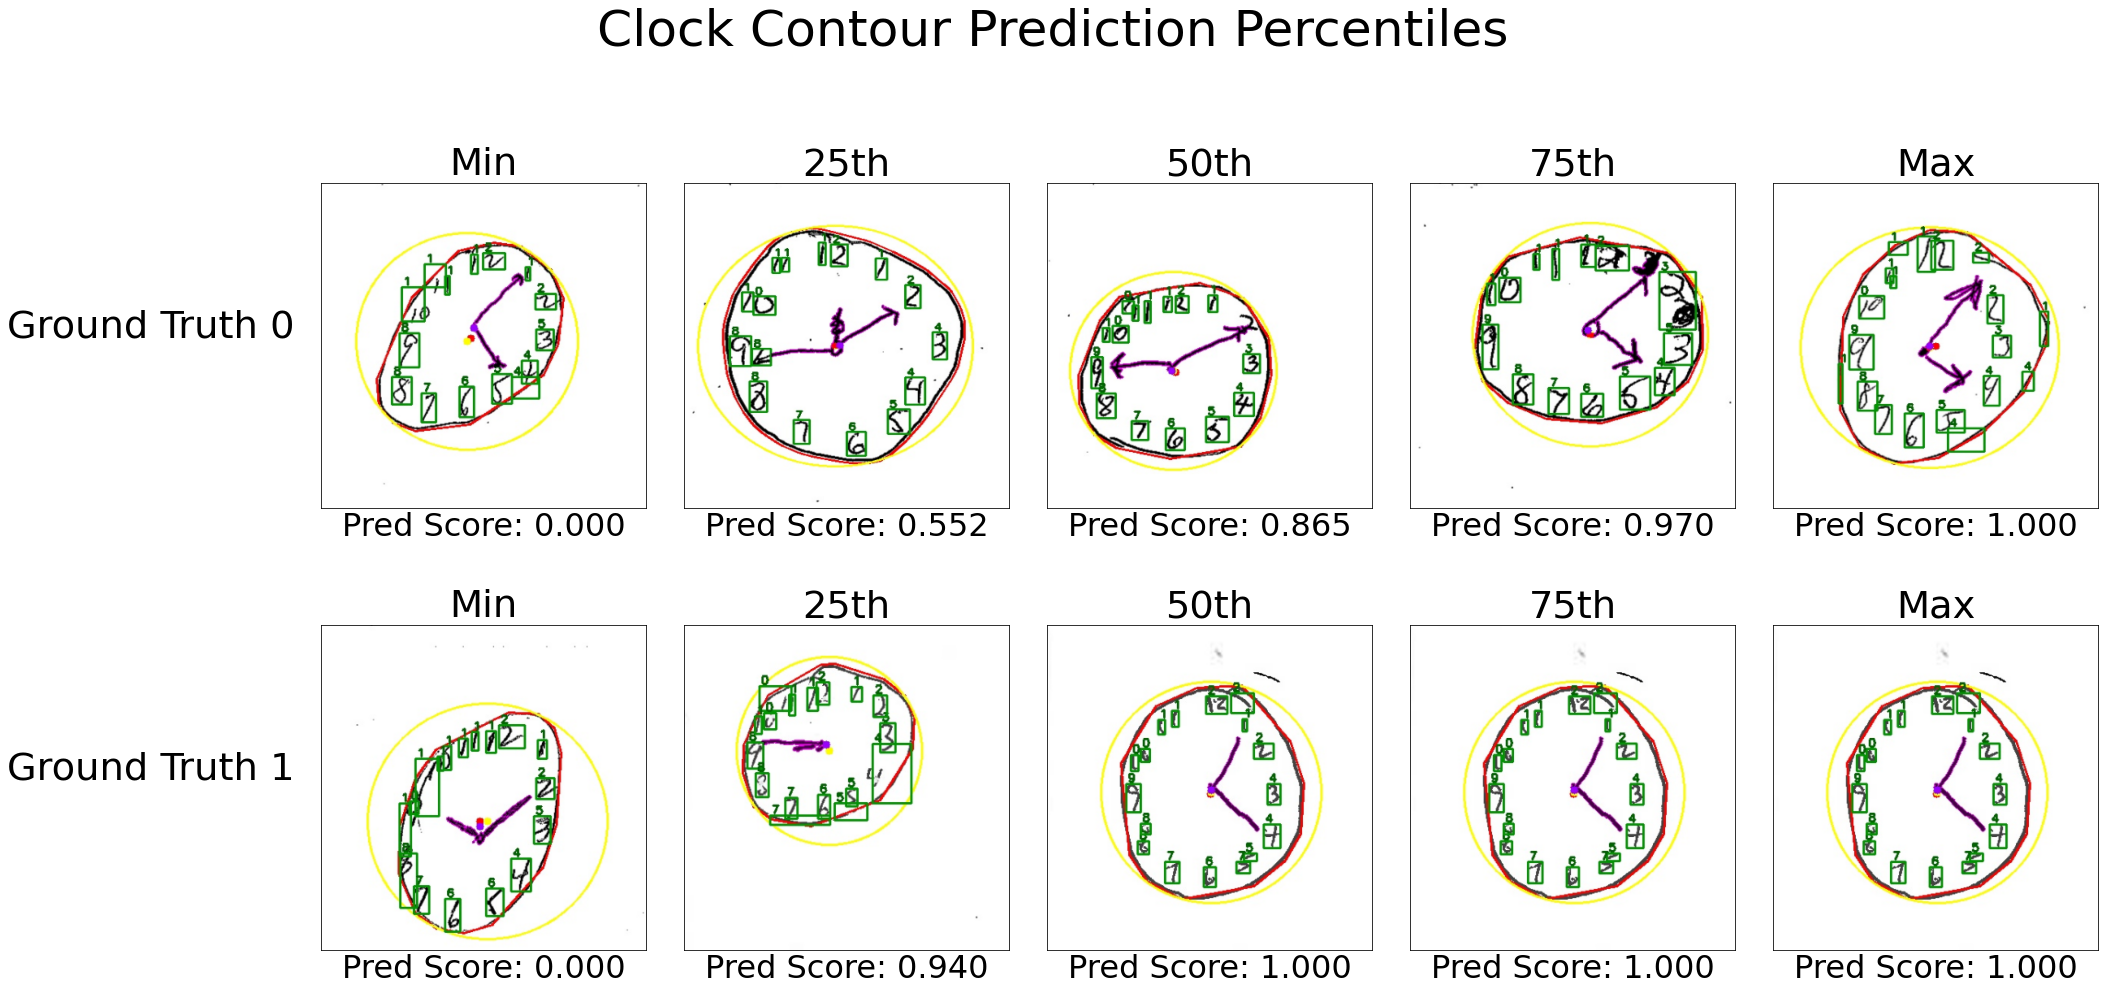

In [103]:
df = forest_df
percentile_list = [0.0, 25.0, 50.0, 75.0, 100.0]
names = ["Contour"]
truths = ["ClockContour"]
predictions = ["Forest_Contour"]

print(len(forest_df))
for i in range(len(names)):
    plt.suptitle(names[i] + " Percentile Prediction Scores")
    true_zeros = df[df[truths[i]] == 0]
    print(len(true_zeros))
    true_ones = df[df[truths[i]] == 1]
    print(len(true_ones))
    zero_preds = true_zeros[predictions[i]]
    one_preds = true_ones[predictions[i]]

    zero_percentiles = np.percentile(np.array(zero_preds), percentile_list)
    one_percentiles = np.percentile(np.array(one_preds), percentile_list)
    
    cols = ["Min", "25th", "50th", "75th", "Max"]
    rows = ["Ground Truth 0", "Ground Truth 1"]
    
    fig, axes = plt.subplots(2, 5, figsize=(30, 15))
    #fig.tight_layout()
    
    for ax, col in zip(axes[0], cols):
        ax.set_title(col)
        
    for ax, row in zip(axes[:,0], rows):
        ax.set_ylabel(row, rotation=0, size="large", labelpad=170)
        
    plt.rcParams.update({'font.size': 42})
    plt.suptitle("Clock Contour Prediction Percentiles")
    plt.rcParams.update({'font.size': 32})
    
    for j in range(len(zero_percentiles)):
        plt.subplot(2, 5, j+1)
        frame = plt.gca()
        frame.axes.get_xaxis().set_ticks([])
        frame.axes.get_yaxis().set_ticks([])
        score = zero_percentiles[j]
        closest = true_zeros.iloc[(true_zeros[predictions[i]] - score).abs().argsort()[:1]]
        filename = list(closest["filename"])[0]
        print(filename)
        image = cv2.imread(directory + filename)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        image = cv2.resize(image, (400, 400))
        #plt.axis('off')

        plt.title(cols[j])
        plt.xlabel("Pred Score: " + str("{:.3f}".format(score)))
        plt.imshow(image)

    for j in range(len(one_percentiles)):
        plt.subplot(2, 5, j+6)
        frame = plt.gca()
        frame.axes.get_xaxis().set_ticks([])
        frame.axes.get_yaxis().set_ticks([])
        score = one_percentiles[j]
        closest = true_ones.iloc[(true_ones[predictions[i]] - score).abs().argsort()[:1]]
        filename = list(closest["filename"])[0]
        image = cv2.imread(directory + filename)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        image = cv2.resize(image, (400, 400))
        #plt.axis('off')
        plt.title(cols[j])
        plt.xlabel("Pred Score: " + str("{:.3f}".format(score)))
        plt.imshow(image)
        
    plt.savefig("results/Contour_Percentiles")
    plt.show()
    

## 4.2 Clock Hands Percentile Predictions

541
825
W52813 V1 02-16-2017.jpg
W61308 V1 1-2-2019.jpg
W62458 V1 5-24-19.jpg
W54648 V2 07-30-2018.jpg
W49318 V1 08-18-2015.jpg


<Figure size 1512x1116 with 0 Axes>

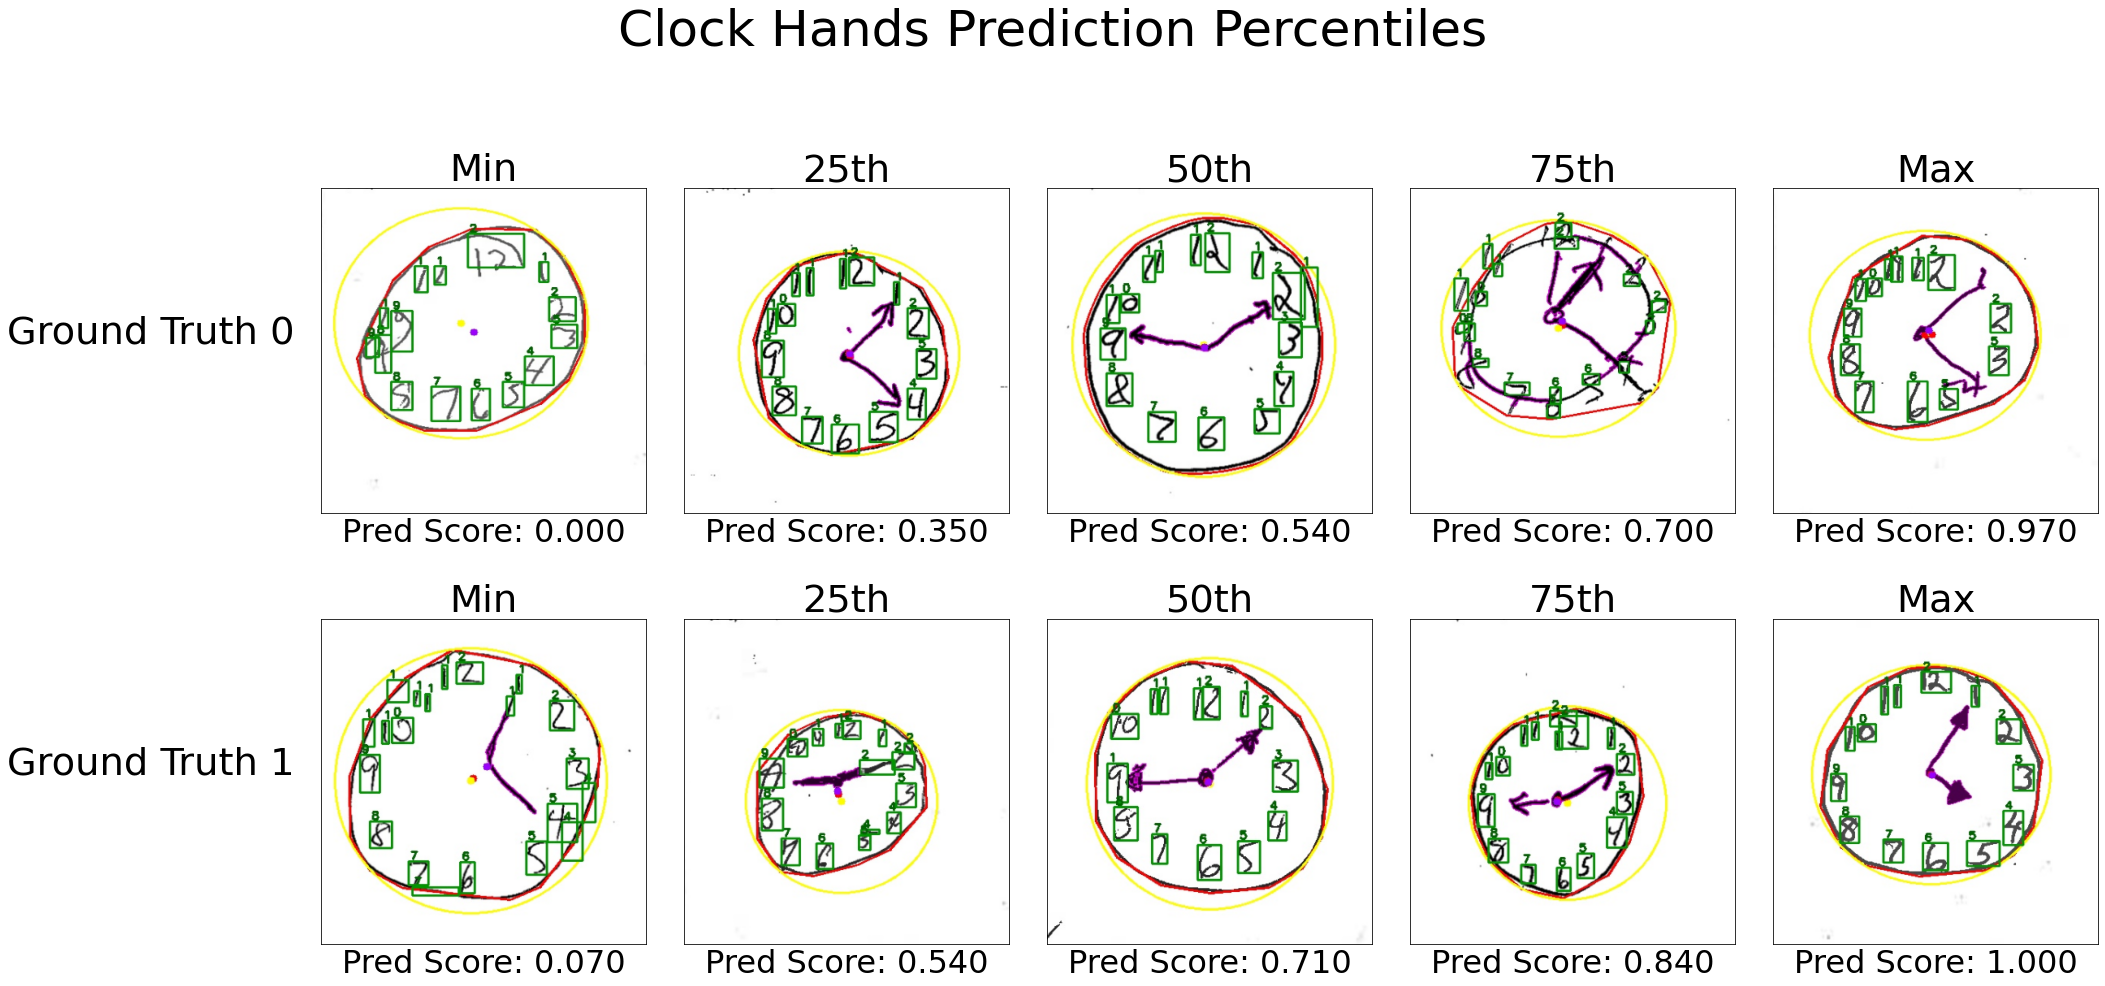

In [104]:
percentile_list = [0.0, 25.0, 50.0, 75.0, 100.0]
names = ["Hands"]
truths = ["ClockHands"]
predictions = ["Forest_Hands"]

for i in range(len(names)):
    plt.suptitle(names[i] + " Percentile Prediction Scores")
    true_zeros = df[df[truths[i]] == 0]
    print(len(true_zeros))
    true_ones = df[df[truths[i]] == 1]
    print(len(true_ones))
    zero_preds = true_zeros[predictions[i]]
    one_preds = true_ones[predictions[i]]

    zero_percentiles = np.percentile(np.array(zero_preds), percentile_list)
    one_percentiles = np.percentile(np.array(one_preds), percentile_list)
    
    cols = ["Min", "25th", "50th", "75th", "Max"]
    rows = ["Ground Truth 0", "Ground Truth 1"]
    
    fig, axes = plt.subplots(2, 5, figsize=(30, 15))
    #fig.tight_layout()
    plt.rcParams.update({'font.size': 42})
    plt.suptitle("Clock Hands Prediction Percentiles")
    plt.rcParams.update({'font.size': 32})
    
    for ax, col in zip(axes[0], cols):
        ax.set_title(col)
        
    for ax, row in zip(axes[:,0], rows):
        ax.set_ylabel(row, rotation=0, size="large", labelpad=170)
    
    for j in range(len(zero_percentiles)):
        plt.subplot(2, 5, j+1)
        frame = plt.gca()
        frame.axes.get_xaxis().set_ticks([])
        frame.axes.get_yaxis().set_ticks([])
        score = zero_percentiles[j]
        closest = true_zeros.iloc[(true_zeros[predictions[i]] - score).abs().argsort()[:1]]
        filename = list(closest["filename"])[0]
        print(filename)
        image = cv2.imread(directory + filename)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        image = cv2.resize(image, (400, 400))
        #plt.axis('off')
        plt.rcParams.update({'font.size': 32})
        plt.title(cols[j])
        plt.xlabel("Pred Score: " + str("{:.3f}".format(score)))
        plt.imshow(image)

    for j in range(len(one_percentiles)):
        plt.subplot(2, 5, j+6)
        frame = plt.gca()
        frame.axes.get_xaxis().set_ticks([])
        frame.axes.get_yaxis().set_ticks([])
        score = one_percentiles[j]
        closest = true_ones.iloc[(true_ones[predictions[i]] - score).abs().argsort()[:1]]
        filename = list(closest["filename"])[0]
        image = cv2.imread(directory + filename)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        image = cv2.resize(image, (400, 400))
        #plt.axis('off')
        plt.title(cols[j])
        plt.xlabel("Pred Score: " + str("{:.3f}".format(score)))
        plt.imshow(image)
        
        plt.savefig("results/Hands_Percentiles")
    plt.show()

## 4.3 Clock Digits Percentile Predictions

134
1232
W61739 V1 1-11-2019.jpg
W48694 03-26-2015 V1.jpg
W59648 V1 08-3-2018.jpg
W61898 V1 4-9-2019.jpg
W55485 V2 11-28-2018.jpg


<Figure size 1512x1116 with 0 Axes>

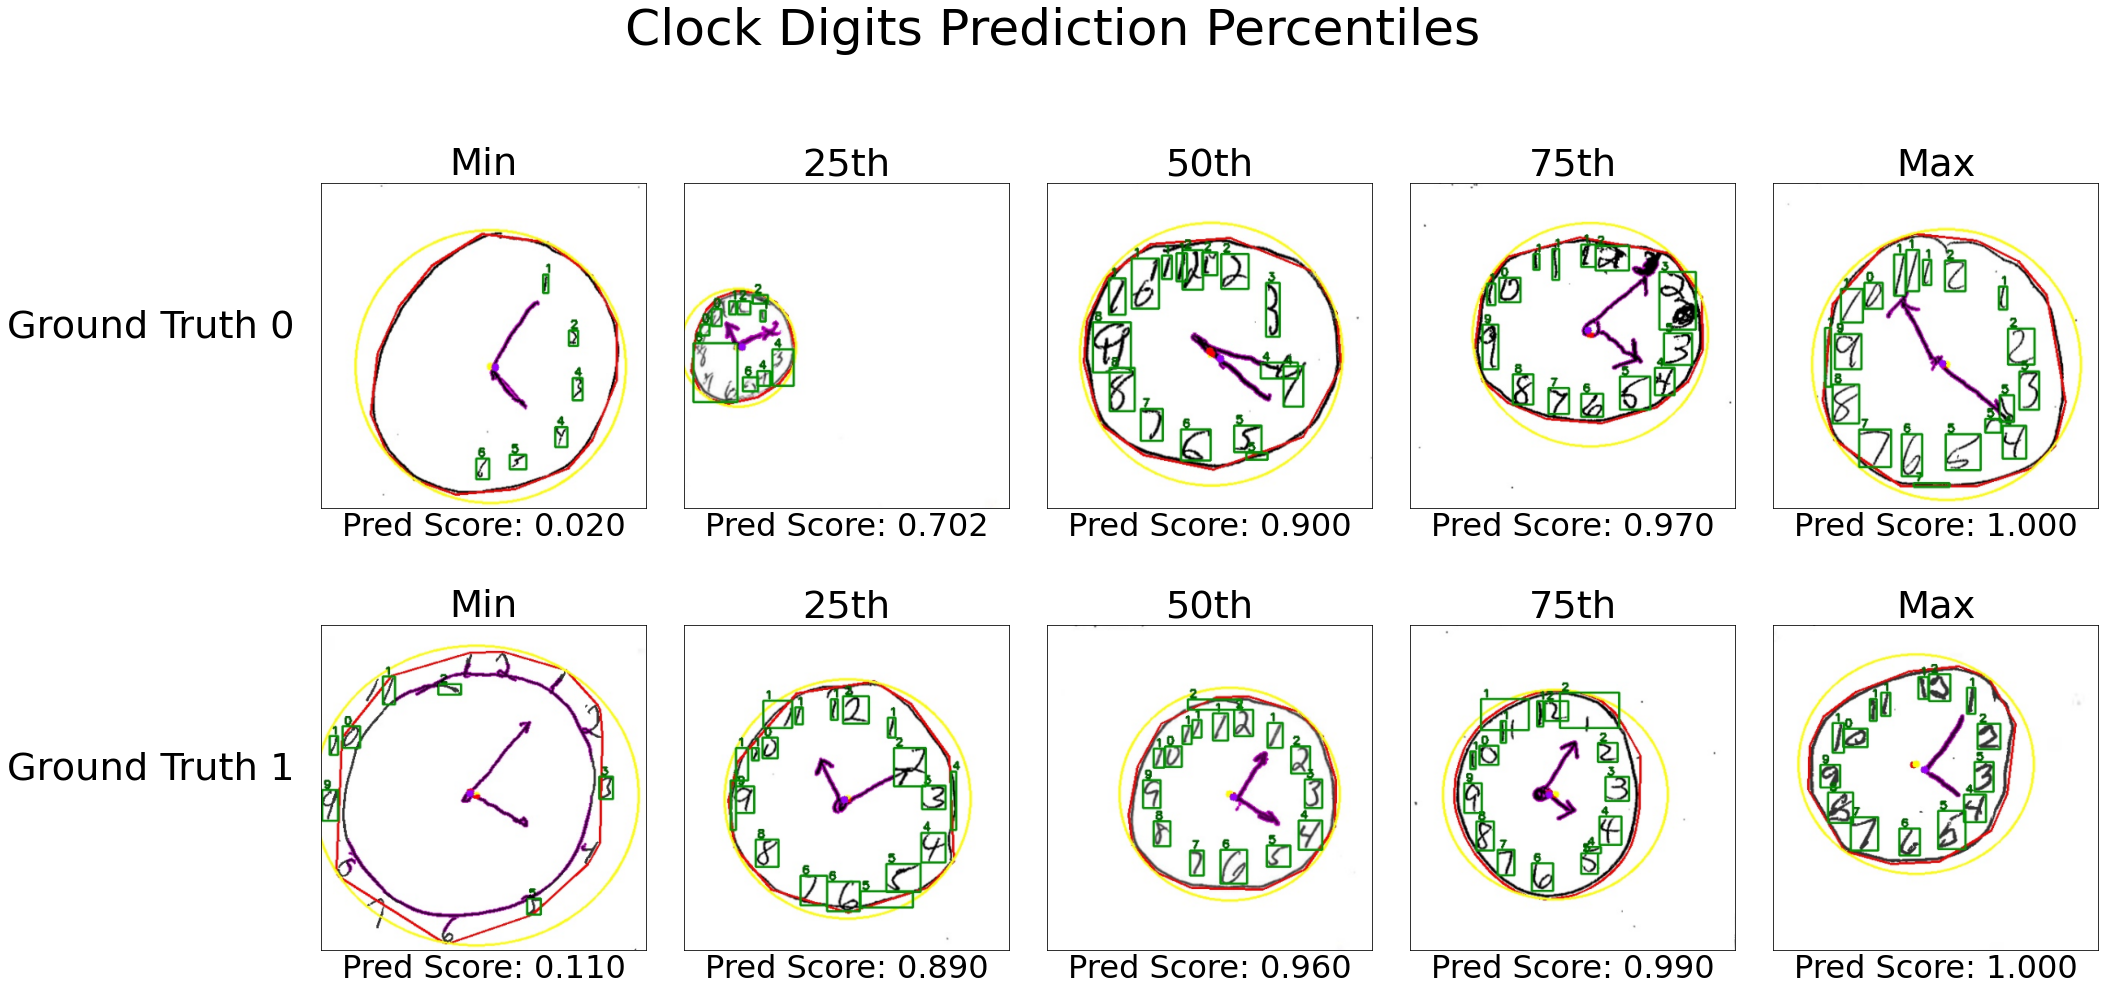

In [105]:
percentile_list = [0.0, 25.0, 50.0, 75.0, 100.0]
names = ["Digits"]
truths = ["ClockNumbers"]
predictions = ["Forest_Digits"]

for i in range(len(names)):
    plt.suptitle(names[i] + " Percentile Prediction Scores")
    true_zeros = df[df[truths[i]] == 0]
    print(len(true_zeros))
    true_ones = df[df[truths[i]] == 1]
    print(len(true_ones))
    zero_preds = true_zeros[predictions[i]]
    one_preds = true_ones[predictions[i]]

    zero_percentiles = np.percentile(np.array(zero_preds), percentile_list)
    one_percentiles = np.percentile(np.array(one_preds), percentile_list)
    
    cols = ["Min", "25th", "50th", "75th", "Max"]
    rows = ["Ground Truth 0", "Ground Truth 1"]
    
    fig, axes = plt.subplots(2, 5, figsize=(30, 15))
    #fig.tight_layout()
    plt.rcParams.update({'font.size': 42})
    plt.suptitle("Clock Digits Prediction Percentiles")
    plt.rcParams.update({'font.size': 32})
    
    for ax, col in zip(axes[0], cols):
        ax.set_title(col)
        
    for ax, row in zip(axes[:,0], rows):
        ax.set_ylabel(row, rotation=0, size="large", labelpad=170)
    
    for j in range(len(zero_percentiles)):
        plt.subplot(2, 5, j+1)
        frame = plt.gca()
        frame.axes.get_xaxis().set_ticks([])
        frame.axes.get_yaxis().set_ticks([])
        score = zero_percentiles[j]
        closest = true_zeros.iloc[(true_zeros[predictions[i]] - score).abs().argsort()[:1]]
        filename = list(closest["filename"])[0]
        print(filename)
        image = cv2.imread(directory + filename)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        image = cv2.resize(image, (400, 400))
        #plt.axis('off')
        plt.rcParams.update({'font.size': 32})
        plt.title(cols[j])
        plt.xlabel("Pred Score: " + str("{:.3f}".format(score)))
        plt.imshow(image)

    for j in range(len(one_percentiles)):
        plt.subplot(2, 5, j+6)
        frame = plt.gca()
        frame.axes.get_xaxis().set_ticks([])
        frame.axes.get_yaxis().set_ticks([])
        score = one_percentiles[j]
        closest = true_ones.iloc[(true_ones[predictions[i]] - score).abs().argsort()[:1]]
        filename = list(closest["filename"])[0]
        image = cv2.imread(directory + filename)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        image = cv2.resize(image, (400, 400))
        #plt.axis('off')
        plt.title(cols[j])
        plt.xlabel("Pred Score: " + str("{:.3f}".format(score)))
        plt.imshow(image)
        
    plt.savefig("results/Digits_Percentiles")
    plt.show()
    

# 5. Tossed Data (Bad Ink)

<Figure size 1512x1116 with 0 Axes>

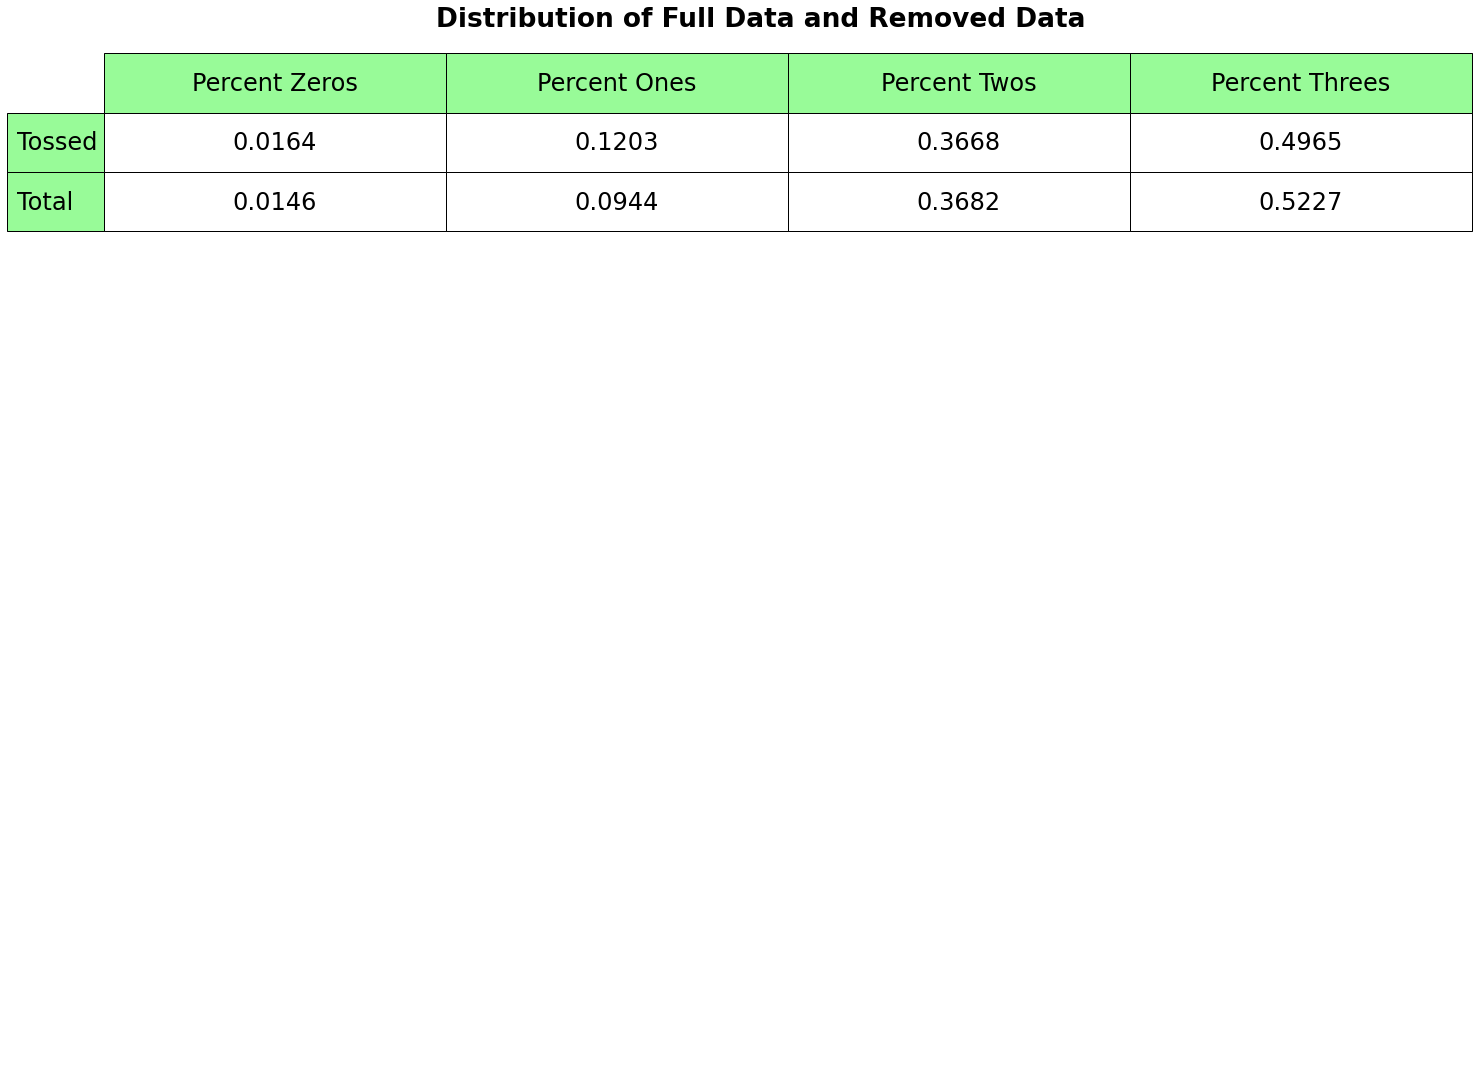

In [33]:
junk_data_file = "SVM_full_data.csv"
junk = pd.read_csv(junk_data_file)
junk.drop(junk[junk["LeftoverInk"] < junk_thresh].index, inplace=True)

junk_truths = junk["ClockContour"] + junk["ClockHands"] + junk["ClockNumbers"]
junk_truths = np.array(junk_truths)
total_truths = np.array(df["Total"])

table_lines = []

decimals = 4
header = ["Percent Zeros", "Percent Ones", "Percent Twos", "Percent Threes"]
names = ["Tossed", "Total"]


weights = np.ones_like(junk_truths)/float(len(junk_truths))
n, _, _ = plt.hist(junk_truths, bins=4, weights=weights, edgecolor="black", density=False, color=colors[i], range=[0, 3])
table_lines.append(np.round(n, decimals=decimals))
weights = np.ones_like(total_truths)/float(len(total_truths))
n, _, _ = plt.hist(total_truths, bins=4, weights=weights, edgecolor="black", density=False, color=colors[i], range=[0, 3])
table_lines.append(np.round(n, decimals=decimals))        

plt.clf()
plt.rcParams["figure.figsize"] = [21.00, 15.50]
plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots()
plt.rcParams.update({'font.size': 22})
ax.axis('tight')
ax.axis('off')
table = ax.table(
    cellText = table_lines,
    rowLabels = names,
    colLabels = header,
    rowColours =["palegreen"] * 10,
    colColours =["palegreen"] * 10, 
    cellLoc ='center',  
    loc ='upper left')

table.auto_set_font_size(False)
table.set_fontsize(24)
table.scale(1, 4)
ax.set_title('Distribution of Full Data and Removed Data', 
             fontweight ="bold")
plt.show()

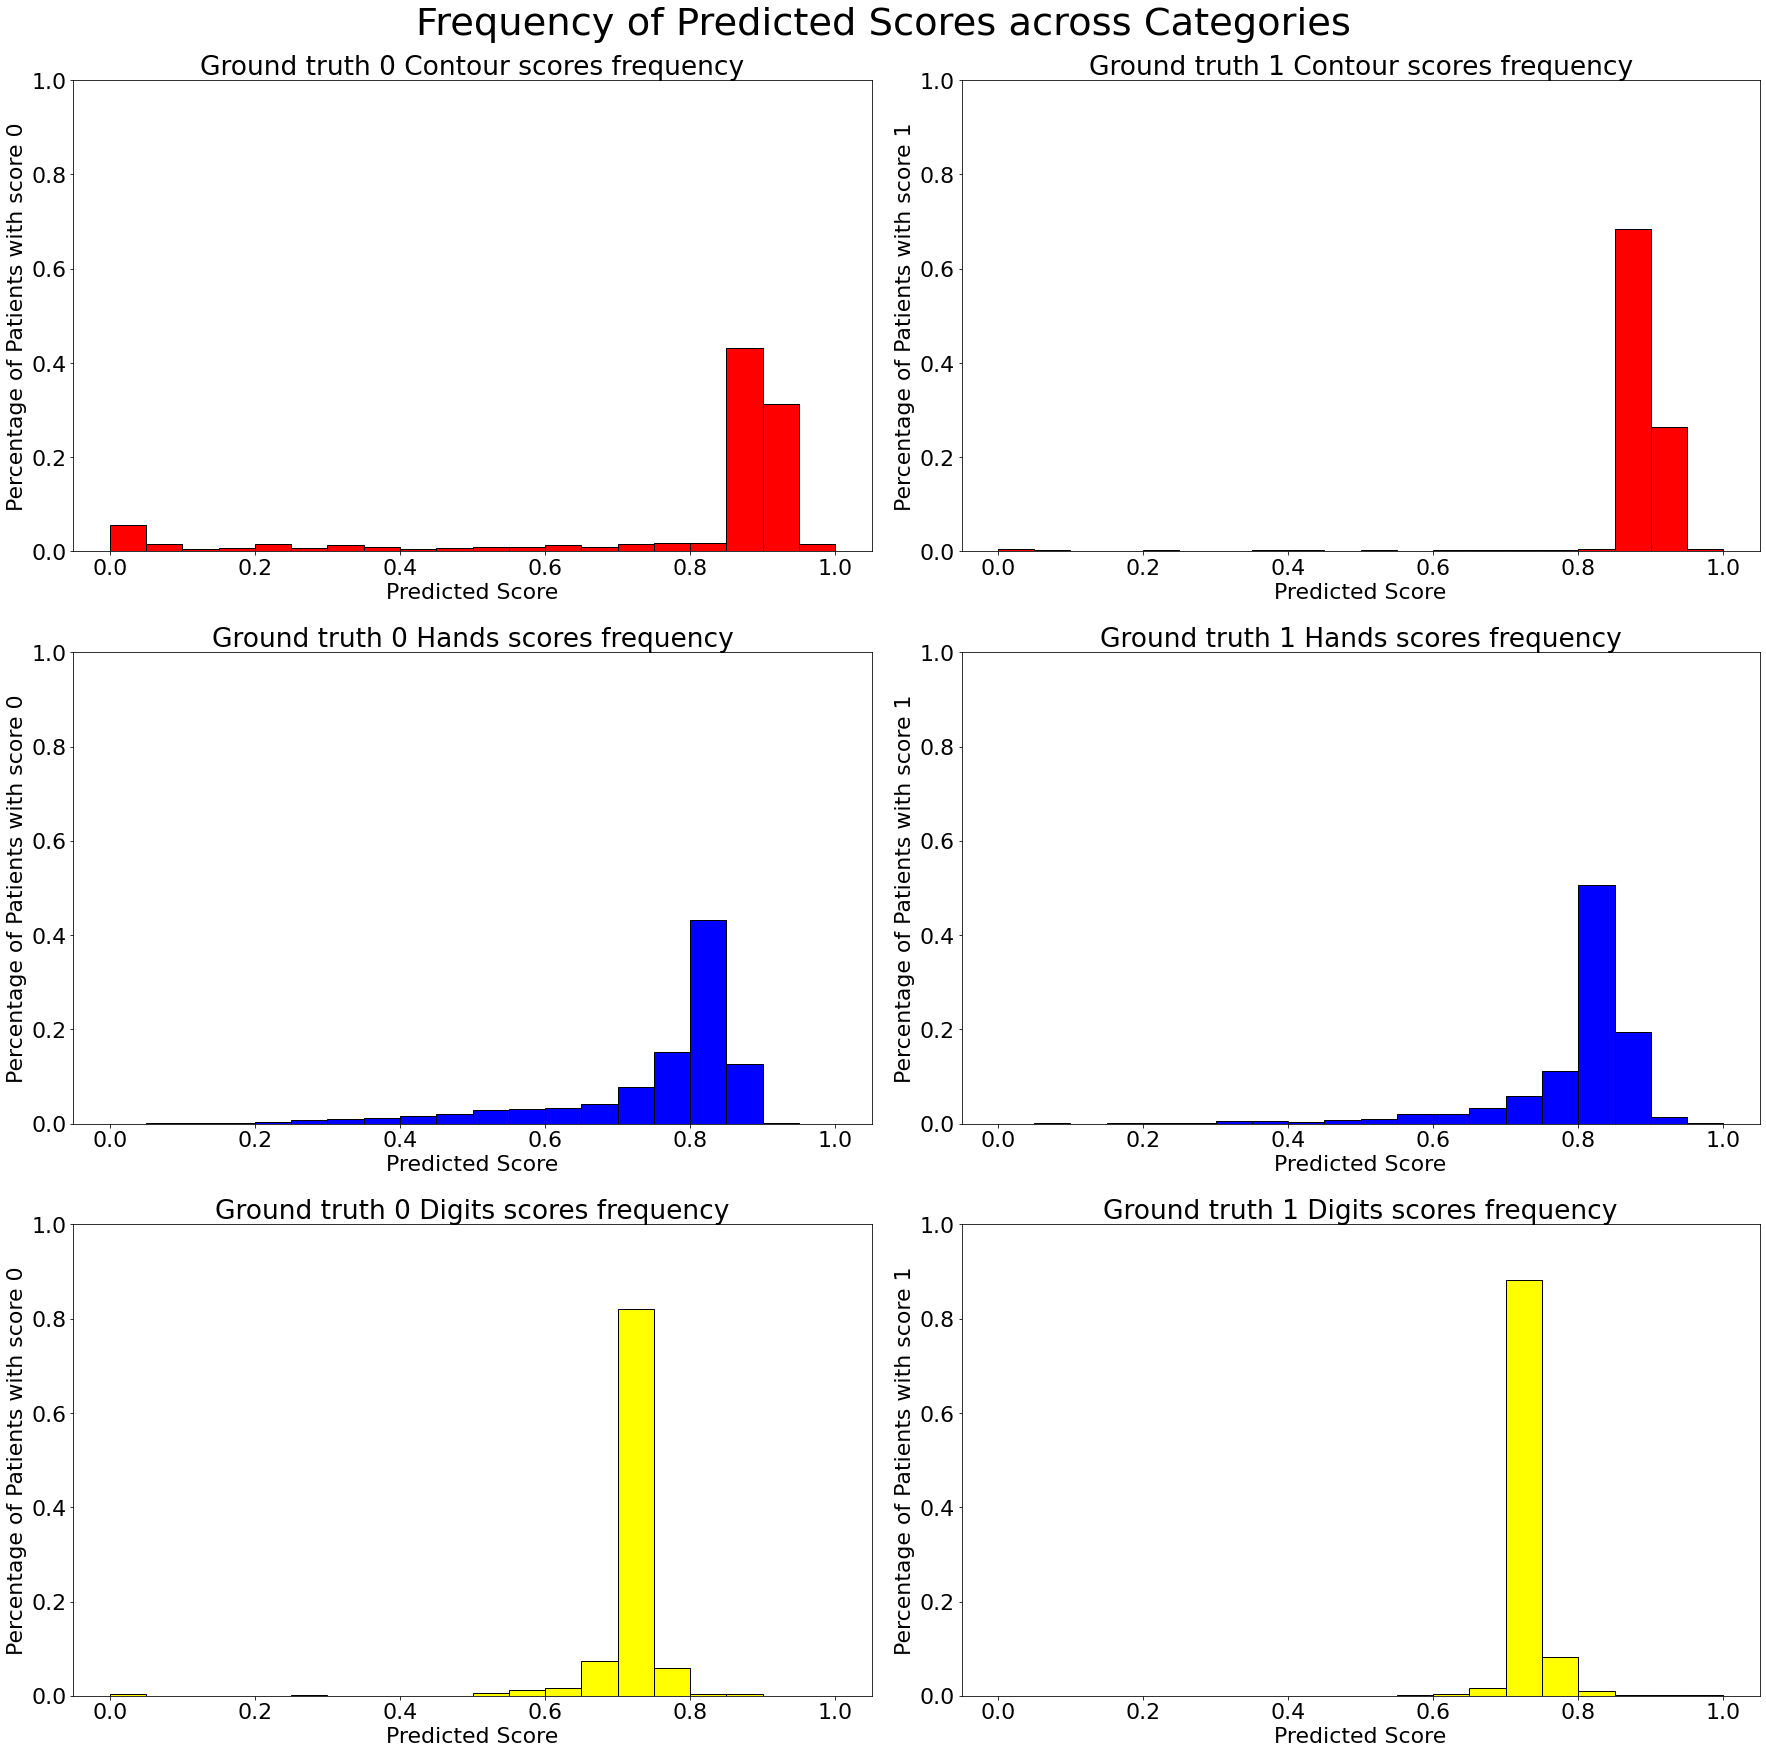

Number of Patients with Contour Score 0: 146
Number of Patients with Contour Score 1: 1220

Number of Patients with Hands Score 0: 541
Number of Patients with Hands Score 1: 825

Number of Patients with Digits Score 0: 134
Number of Patients with Digits Score 1: 1232



In [34]:
junk["Total"] = junk["ClockContour"] + junk["ClockHands"] + junk["ClockNumbers"]
fig = plt.figure(1, (25, 25))

plt.rcParams.update({'font.size': 32})
plt.suptitle("Frequency of Predicted Scores across Categories")
plt.rcParams.update({'font.size': 22})

colors = ["red", "blue", "yellow"]
names = ["Contour", "Hands", "Digits"]
predictions = ["SVM_Contour_F", "SVM_Hands_Acc", "SVM_Digits_Acc"]

# We can set the number of bins with the `bins` kwarg
for i, category in enumerate(["ClockContour", "ClockHands", "ClockNumbers"]):
    for score in [0, 1]:

        relevant_scores = junk[junk[category] == score]
        predicted_scores = np.array(relevant_scores[predictions[i]])

        weights = np.ones_like(predicted_scores)/float(len(predicted_scores))
        plt.subplot(3, 2, (i*2)+(score+1))
        n, bins, patches = plt.hist(predicted_scores, bins=20, weights=weights, edgecolor="black", density=False, color=colors[i], range=[0, 1])
        plt.xlabel("Predicted Score")
        #plt.xticks(ticks=[0.5, 1.5], labels=[0, 1])
        plt.ylabel("Percentage of Patients with score " + (str(score)))
        plt.title("Ground truth " + str(score) + " " + names[i] + " scores frequency")
        plt.ylim(0, 1)
plt.show()

for i, category in enumerate(["ClockContour", "ClockHands", "ClockNumbers"]):
    for score in [0, 1]:
        relevant_scores = df[df[category] == score]
        print("Number of Patients with " + str(names[i]) + " Score " + str(score) + ": " + str(len(relevant_scores)))
    print("")

# 6. Age Dot Plots

1366
1366


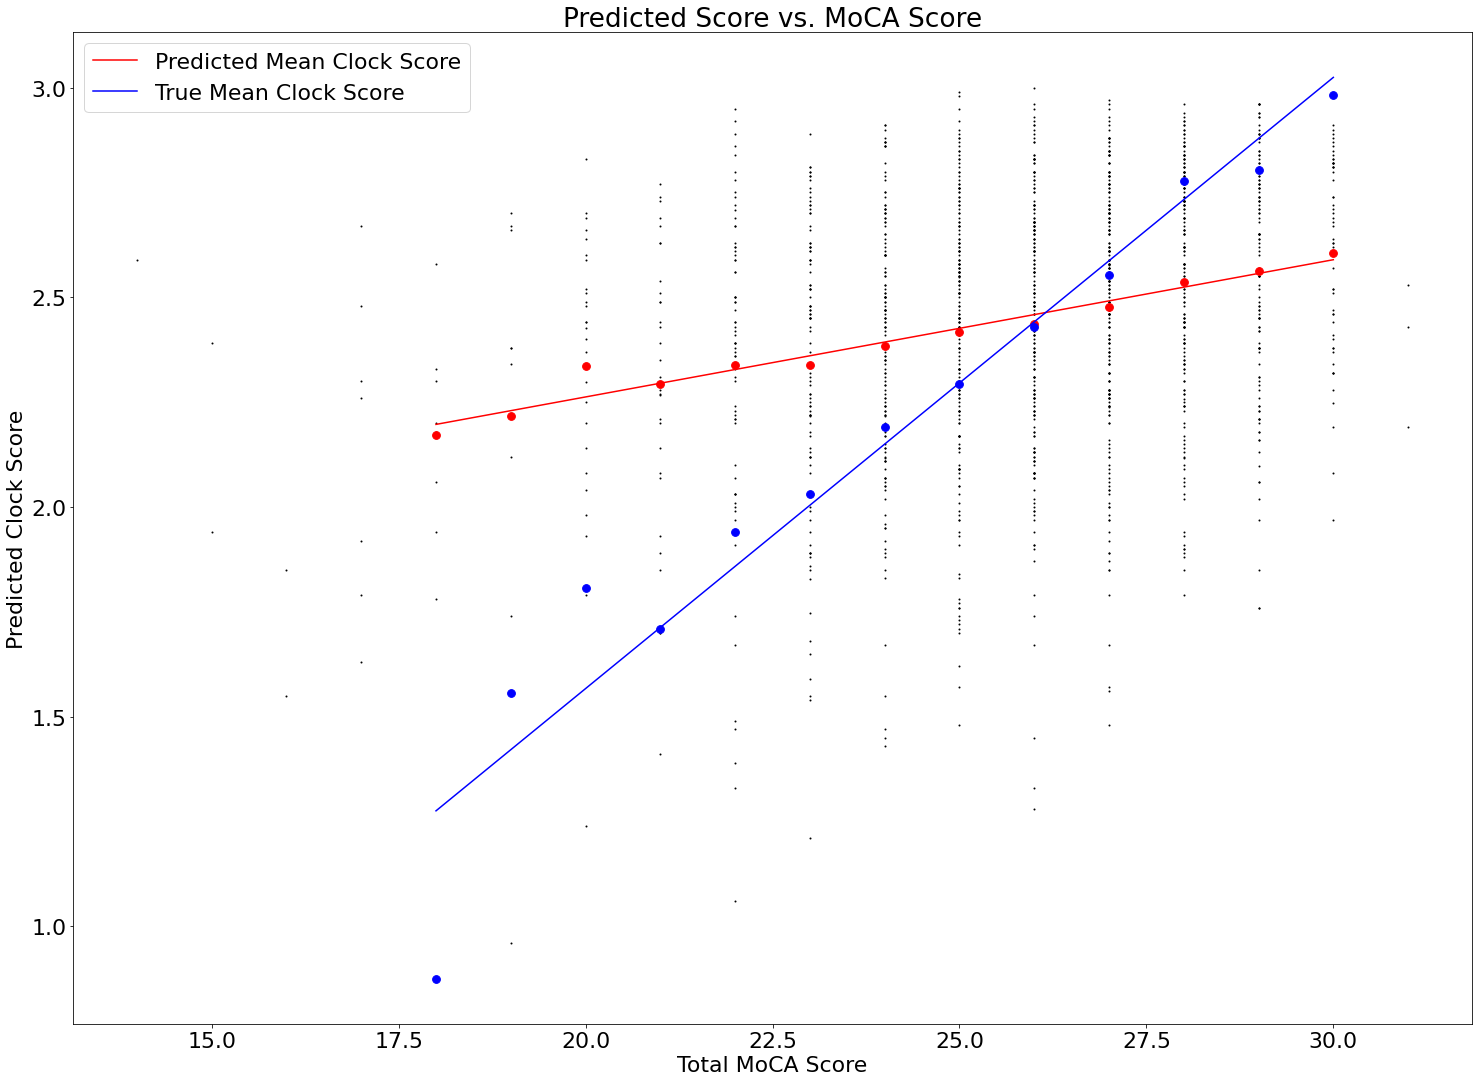

In [177]:
from sklearn.linear_model import SGDRegressor

df = forest_df
print(len(forest_df))
names = ["Ground Truth", "Predicted Score"]
true_scores = np.array(df["Total"])
predicted_scores = np.array(df["Pred_Total"])
ages = np.array(df["agei"])
moca = np.array(df["Score"])
    
# plt.subplot(2, 2, 1)
# plt.scatter(ages, true_scores, s=5)
# plt.xlabel("Patient Age")
# plt.ylabel("Ground Truth Clock Score")
# plt.title("Ground Truth vs. Age")

# plt.subplot(2, 2, 2)
# plt.scatter(ages, predicted_scores, s=5)
# plt.xlabel("Patient Age")
# plt.ylabel("Predicted Clock Score")
# plt.title("Predicted Score vs. Age")

df = forest_df
print(len(forest_df))
age_groups = df.groupby(["agei"]).mean()
age_true_scores = np.array(age_groups["Total"])
age_predicted_scores = np.array(age_groups["Pred_Total"])

moca_groups = df.groupby(["Score"]).mean()
moca_true_scores = np.array(moca_groups["Total"])
moca_predicted_scores = np.array(moca_groups["Pred_Total"])

# plt.subplot(2, 2, 3)
# plt.scatter(moca, true_scores, s=5)
# moca_groups["Total"].plot()
# plt.xlabel("Total MoCA Score")
# plt.ylabel("Ground Truth Clock Score")
# plt.title("Ground Truth vs. MoCA Score")

#plt.subplot(2, 2, 4)
plt.scatter(moca, predicted_scores, s=1, color="black")
#moca_groups["Pred_Total"].plot()

# Bigger dots for the mean predicted scores
moca_groups["Score"] = [i for i in range(14, 32)]
x = np.array(moca_groups["Score"][4:-1])
y = np.array(moca_groups["Pred_Total"][4:-1])
plt.scatter(x, y, s=60, color="red")

# Regression line for the mean predicted scores
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color="red", label="Predicted Mean Clock Score")

y = np.array(moca_groups["Total"][4:-1])
plt.scatter(x, y, s=60, color="blue")
m, b = np.polyfit(x, y, 1,)
plt.plot(x, m*x + b, color="blue", label="True Mean Clock Score")

#print(moca_groups)


plt.xlabel("Total MoCA Score")
plt.ylabel("Predicted Clock Score")
plt.title("Predicted Score vs. MoCA Score")
plt.legend(loc="upper left")

plt.savefig("results/pred_vs_moca.jpg")    
plt.show()

1366


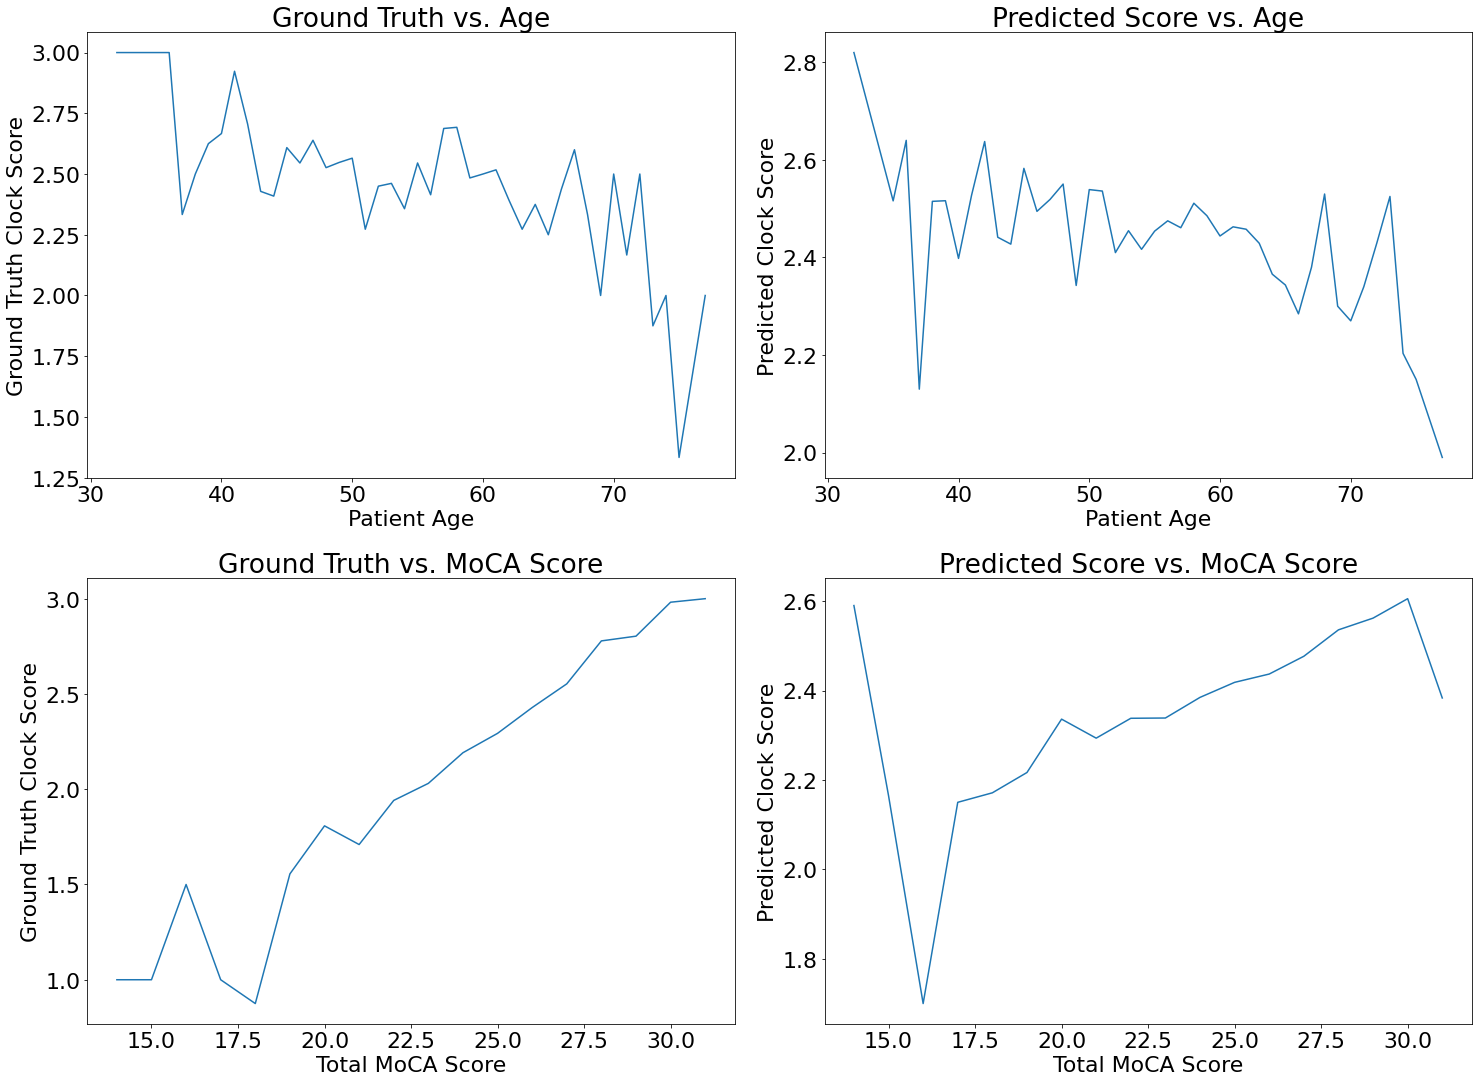

In [29]:
df = forest_df
print(len(forest_df))
age_groups = df.groupby(["agei"]).mean()
age_true_scores = np.array(age_groups["Total"])
age_predicted_scores = np.array(age_groups["Pred_Total"])

moca_groups = df.groupby(["Score"]).mean()
moca_true_scores = np.array(moca_groups["Total"])
moca_predicted_scores = np.array(moca_groups["Pred_Total"])
    
plt.subplot(2, 2, 1)
age_groups["Total"].plot()
plt.xlabel("Patient Age")
plt.ylabel("Ground Truth Clock Score")
plt.title("Ground Truth vs. Age")

plt.subplot(2, 2, 2)
age_groups["Pred_Total"].plot()
plt.xlabel("Patient Age")
plt.ylabel("Predicted Clock Score")
plt.title("Predicted Score vs. Age")

plt.subplot(2, 2, 3)
moca_groups["Total"].plot()
plt.xlabel("Total MoCA Score")
plt.ylabel("Ground Truth Clock Score")
plt.title("Ground Truth vs. MoCA Score")

plt.subplot(2, 2, 4)
moca_groups["Pred_Total"].plot()
plt.xlabel("Total MoCA Score")
plt.ylabel("Predicted Clock Score")
plt.title("Predicted Score vs. MoCA Score")
    
    
plt.show()

# 7. Pearson Correlation

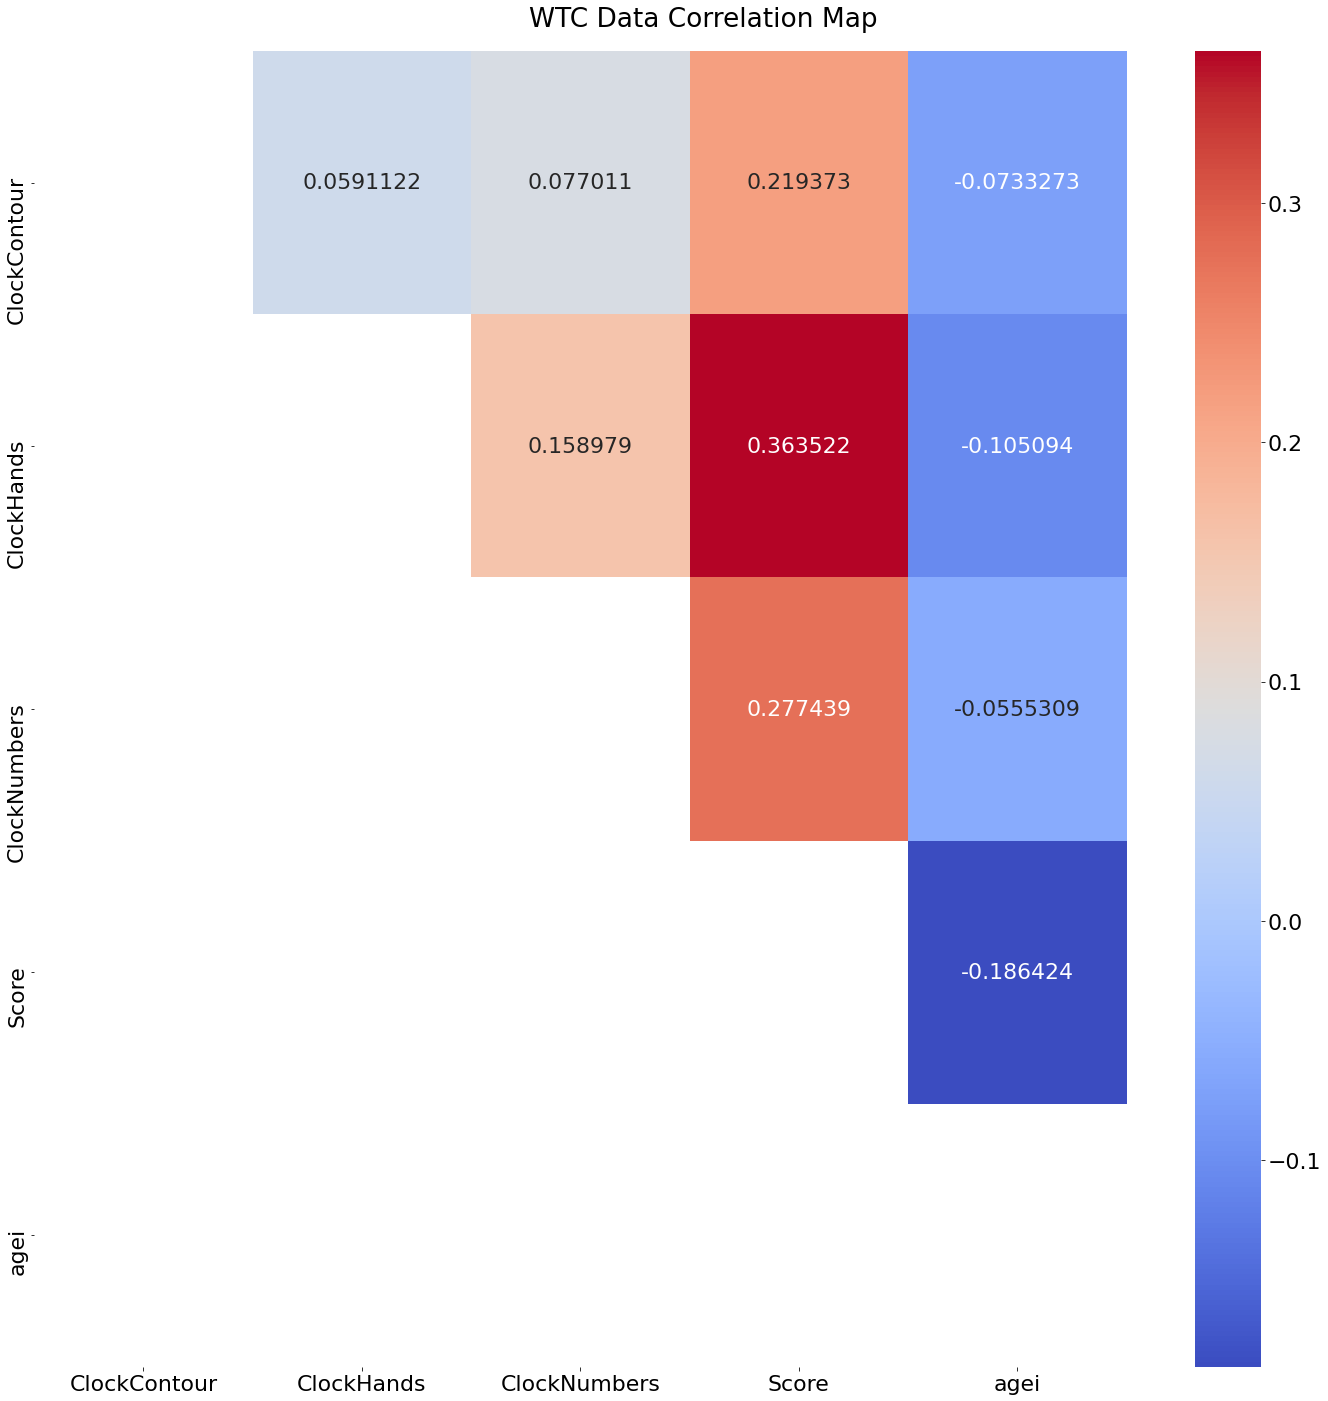

In [30]:
import seaborn
def display_pearson_heatmap():
    plt.figure(1, (20, 20))
    plt.suptitle("WTC Data Correlation Map")
    data = pd.read_csv("full_data.csv")
    #contours = data[['ClockContour', 'Circularity', 'Radius', 'CenterDeviation', 'RemovedPoints']]
    #hands = data[["ClockHands", 'HandsAngle', 'DensityRatio', 'BBRatio', 'LengthRatio', 'IntersectDistance', 'NumComponents']]
    scores = data[["ClockContour", "ClockHands", "ClockNumbers", "Score", "agei"]]

    matrix = np.tril(scores.corr())
    seaborn.heatmap(scores.corr(), fmt='g', cmap='coolwarm', mask=matrix, annot=True)
    plt.savefig("small_data_heatmap")
    plt.show()
    
display_pearson_heatmap()

# 9.1 Contour Feature Importance

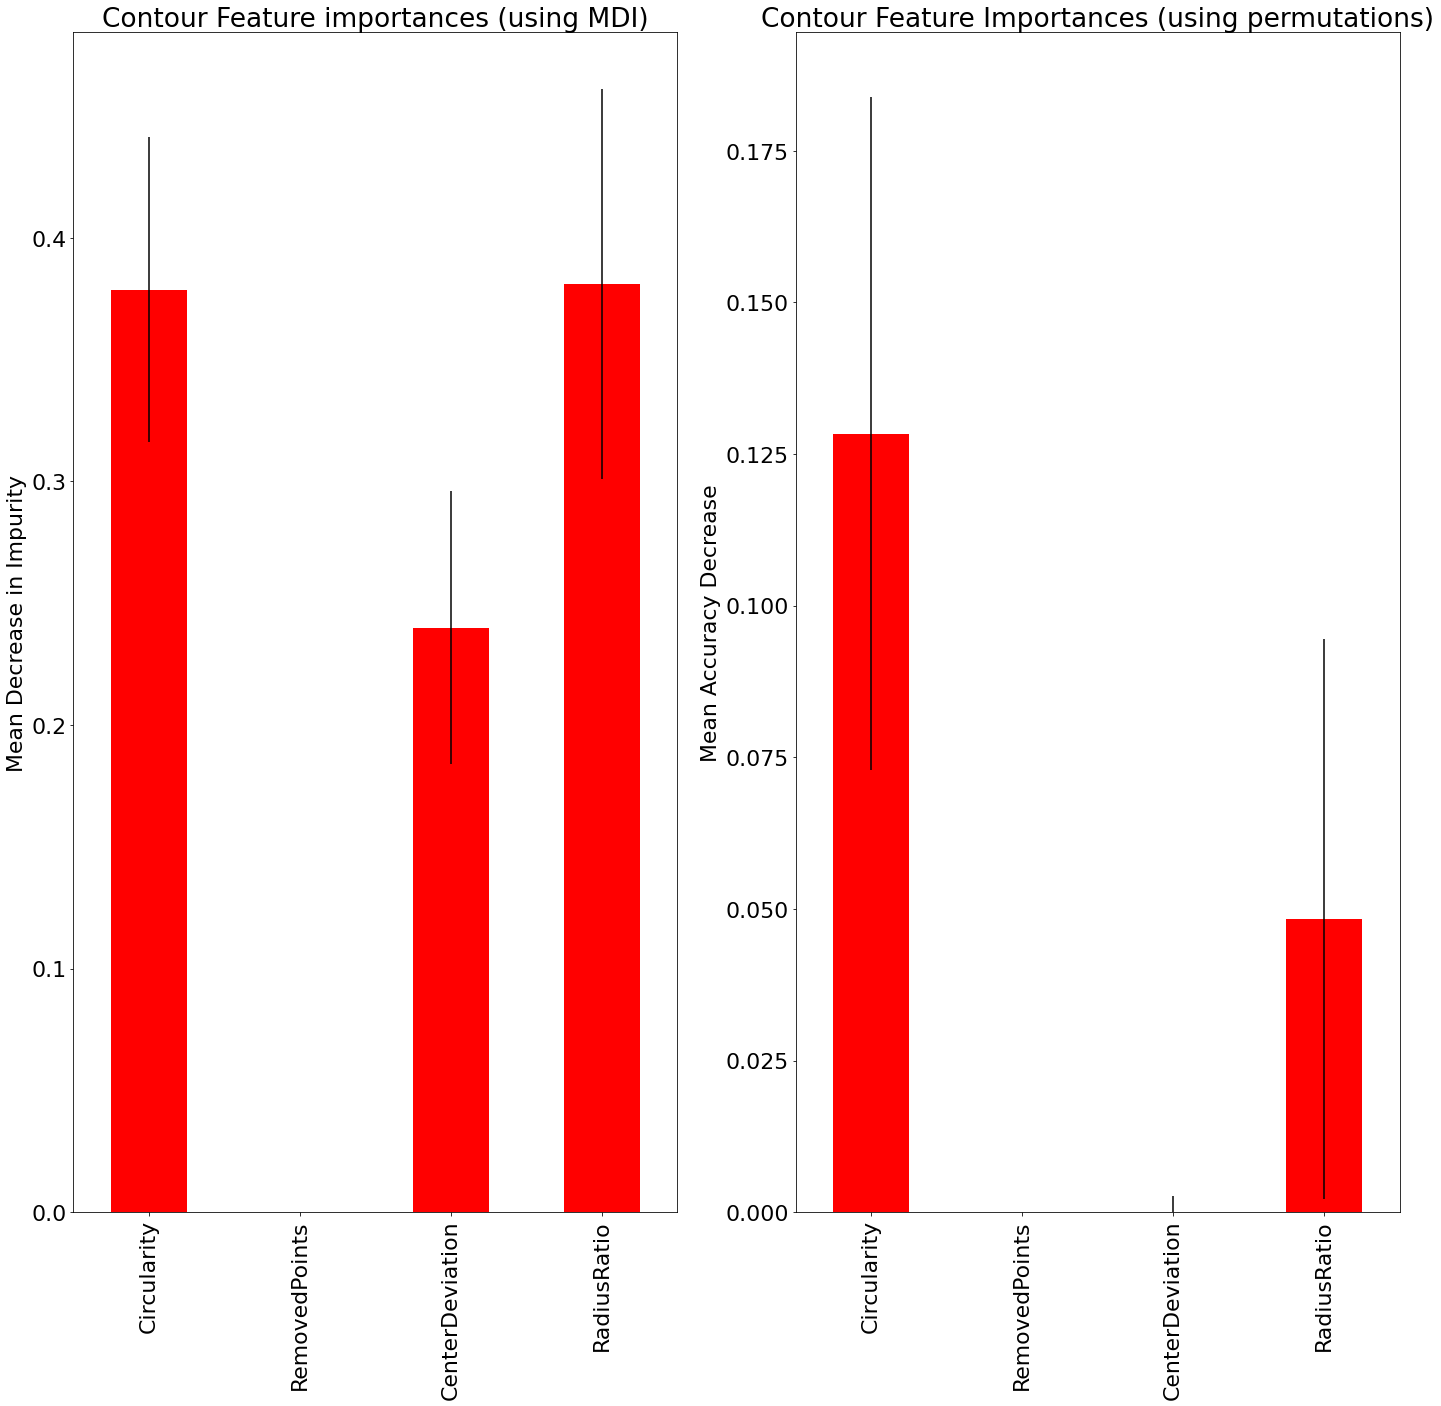

In [35]:
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.inspection import permutation_importance
    
    df = forest_df
    labels = df[["ClockContour"]].to_numpy()
    split_point = int(len(labels) * .8)

    train_labels = labels[:split_point]
    test_labels = labels[split_point:]

    model = RandomForestRegressor()
    feature_set = ["Circularity", "RemovedPoints", "CenterDeviation", "RadiusRatio"]
    data = df[feature_set].to_numpy()
    train_data = data[:split_point]
    test_data = data[split_point:]

    model.fit(train_data, train_labels.ravel())
    
    # MDI importances
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    
    mdi_importances = pd.Series(importances, index=feature_set)
    
    # Feature permutation (shuffle features n times, refit model to determine importance)
    result = permutation_importance(model, test_data, test_labels, n_repeats=10)
    permutation_importances = pd.Series(result.importances_mean, index=feature_set)
    
    plt.figure(1, (20, 20))
    plt.subplot(1, 2, 1)
    mdi_importances.plot.bar(yerr=std, color="red")
    plt.title("Contour Feature importances (using MDI)")
    plt.ylabel("Mean Decrease in Impurity")
    
    plt.subplot(1, 2, 2)
    permutation_importances.plot.bar(yerr=result.importances_std, color="red")
    plt.title("Contour Feature Importances (using permutations)")
    plt.ylabel("Mean Accuracy Decrease")
    plt.ylim(0, )
    
    plt.show()

# 9.2 Hands Feature Importance

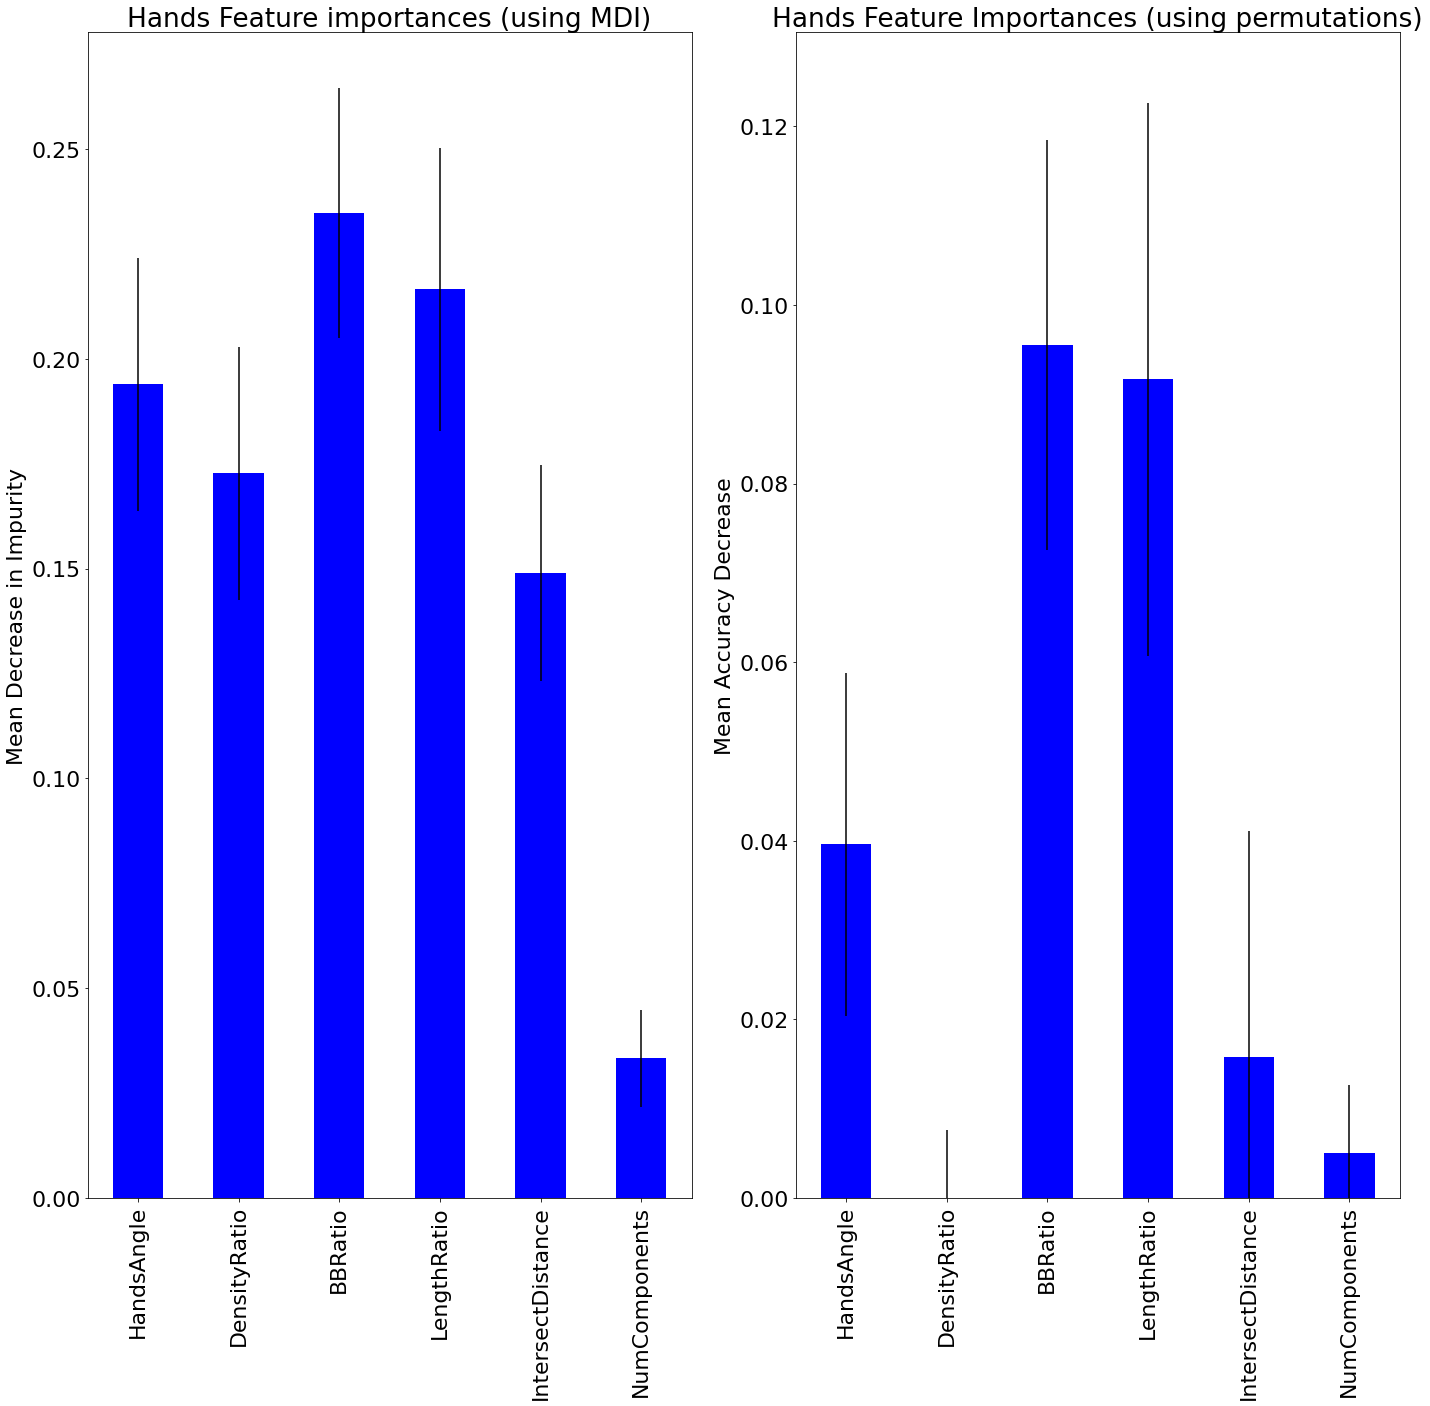

In [38]:
    df = forest_df
    labels = df[["ClockHands"]].to_numpy()
    split_point = int(len(labels) * .8)

    train_labels = labels[:split_point]
    test_labels = labels[split_point:]

    rows_list = []
    # Test all feature combos
    model = RandomForestRegressor()
    feature_set = ["HandsAngle", "DensityRatio", "BBRatio", "LengthRatio", "IntersectDistance", "NumComponents"]
    data = df[feature_set].to_numpy()
    train_data = data[:split_point]
    test_data = data[split_point:]

    model.fit(train_data, train_labels.ravel())
    
    # MDI importances
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    
    mdi_importances = pd.Series(importances, index=feature_set)
    
    # Feature permutation (shuffle features n times, refit model to determine importance)
    result = permutation_importance(model, test_data, test_labels, n_repeats=10)
    permutation_importances = pd.Series(result.importances_mean, index=feature_set)
    
    plt.figure(1, (20, 20))
    plt.subplot(1, 2, 1)
    mdi_importances.plot.bar(yerr=std, color="blue")
    plt.title("Hands Feature importances (using MDI)")
    plt.ylabel("Mean Decrease in Impurity")
    
    plt.subplot(1, 2, 2)
    permutation_importances.plot.bar(yerr=result.importances_std, color="blue")
    plt.title("Hands Feature Importances (using permutations)")
    plt.ylabel("Mean Accuracy Decrease")
    plt.ylim(0, )
    
    plt.show()

# 9.3 Digits Feature Importance

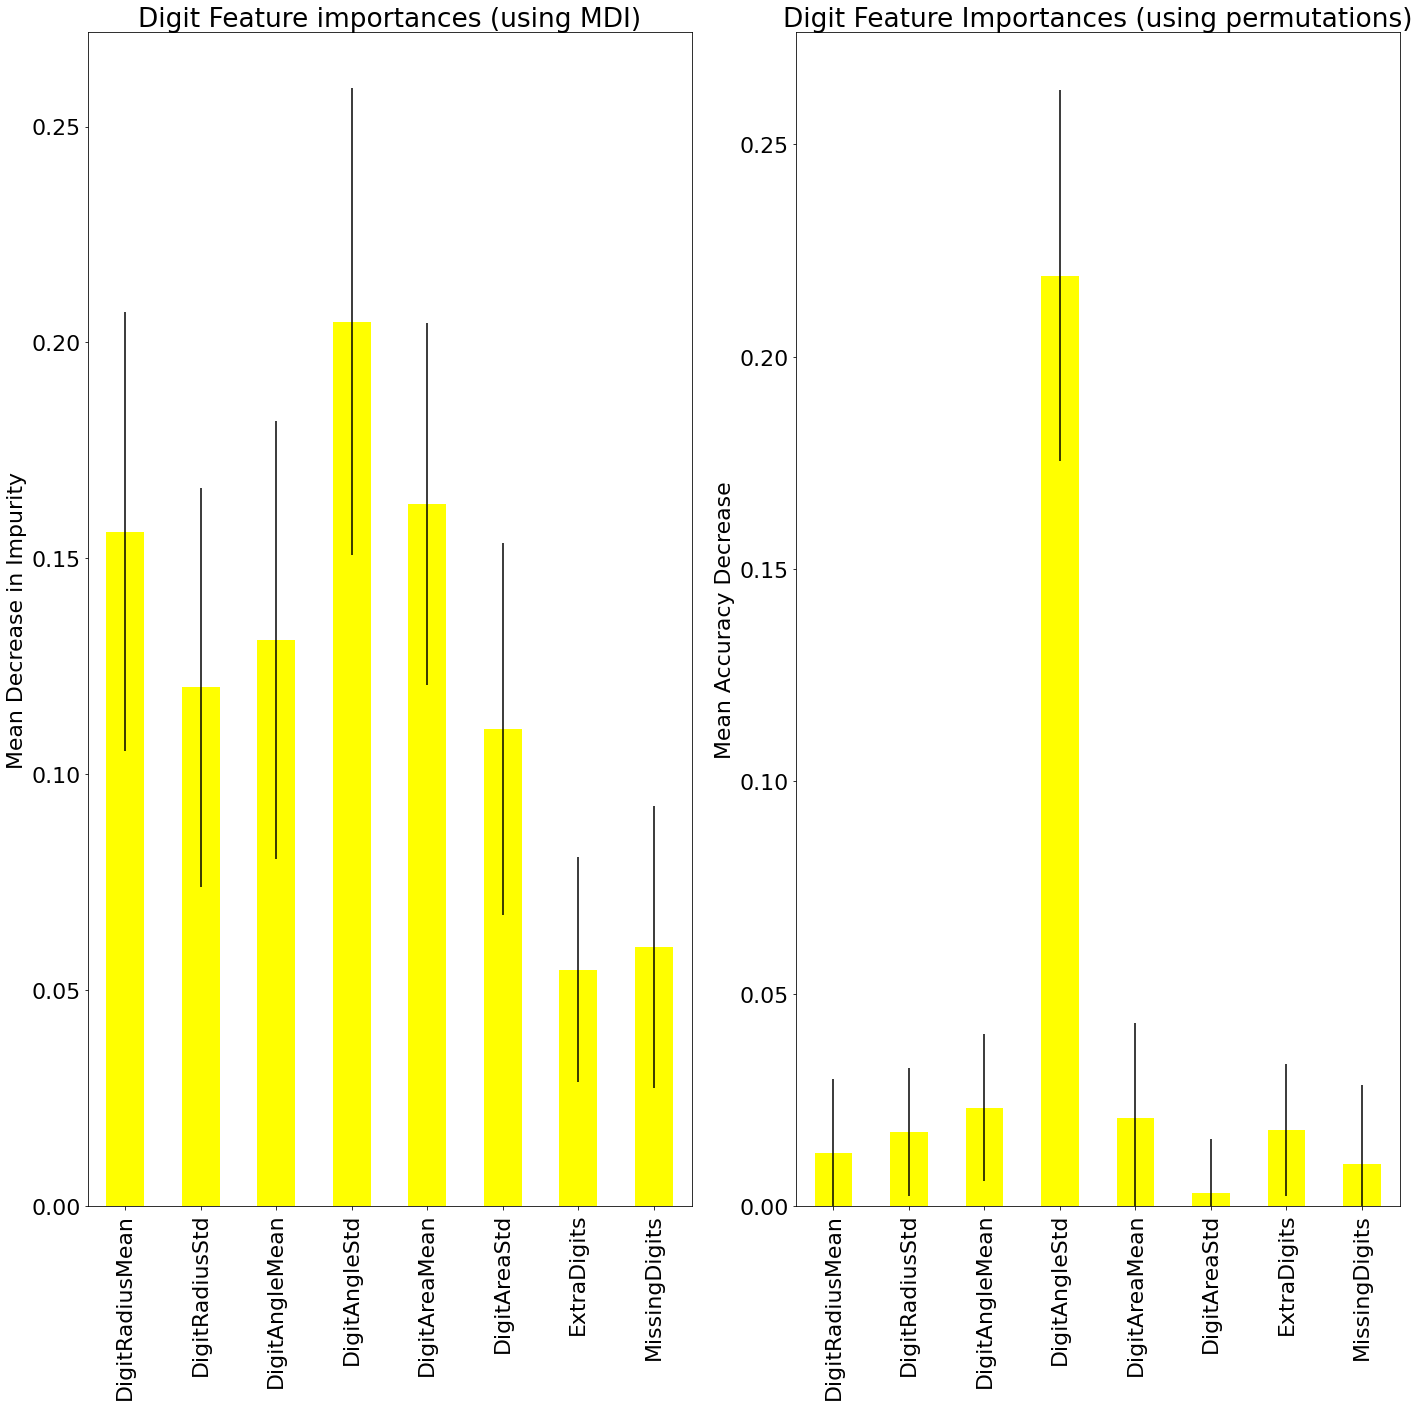

In [33]:
    df = forest_df
    labels = df[["ClockNumbers"]].to_numpy()
    split_point = int(len(labels) * .8)

    train_labels = labels[:split_point]
    test_labels = labels[split_point:]

    rows_list = []
    # Test all feature combos
    model = RandomForestRegressor()
    feature_set = ["DigitRadiusMean", "DigitRadiusStd", "DigitAngleMean", "DigitAngleStd", "DigitAreaMean", "DigitAreaStd",
               "ExtraDigits", "MissingDigits"]
    data = df[feature_set].to_numpy()
    train_data = data[:split_point]
    test_data = data[split_point:]

    model.fit(train_data, train_labels.ravel())
    
    # MDI importances
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    
    mdi_importances = pd.Series(importances, index=feature_set)
    
    # Feature permutation (shuffle features n times, refit model to determine importance)
    result = permutation_importance(model, test_data, test_labels, n_repeats=10)
    permutation_importances = pd.Series(result.importances_mean, index=feature_set)
    
    plt.figure(1, (20, 20))
    plt.subplot(1, 2, 1)
    mdi_importances.plot.bar(yerr=std, color="yellow")
    plt.title("Digit Feature importances (using MDI)")
    plt.ylabel("Mean Decrease in Impurity")
    
    plt.subplot(1, 2, 2)
    permutation_importances.plot.bar(yerr=result.importances_std, color="yellow")
    plt.title("Digit Feature Importances (using permutations)")
    plt.ylabel("Mean Accuracy Decrease")
    plt.ylim(0, )
    
    plt.show()

# 10. Feature Correlation Maps

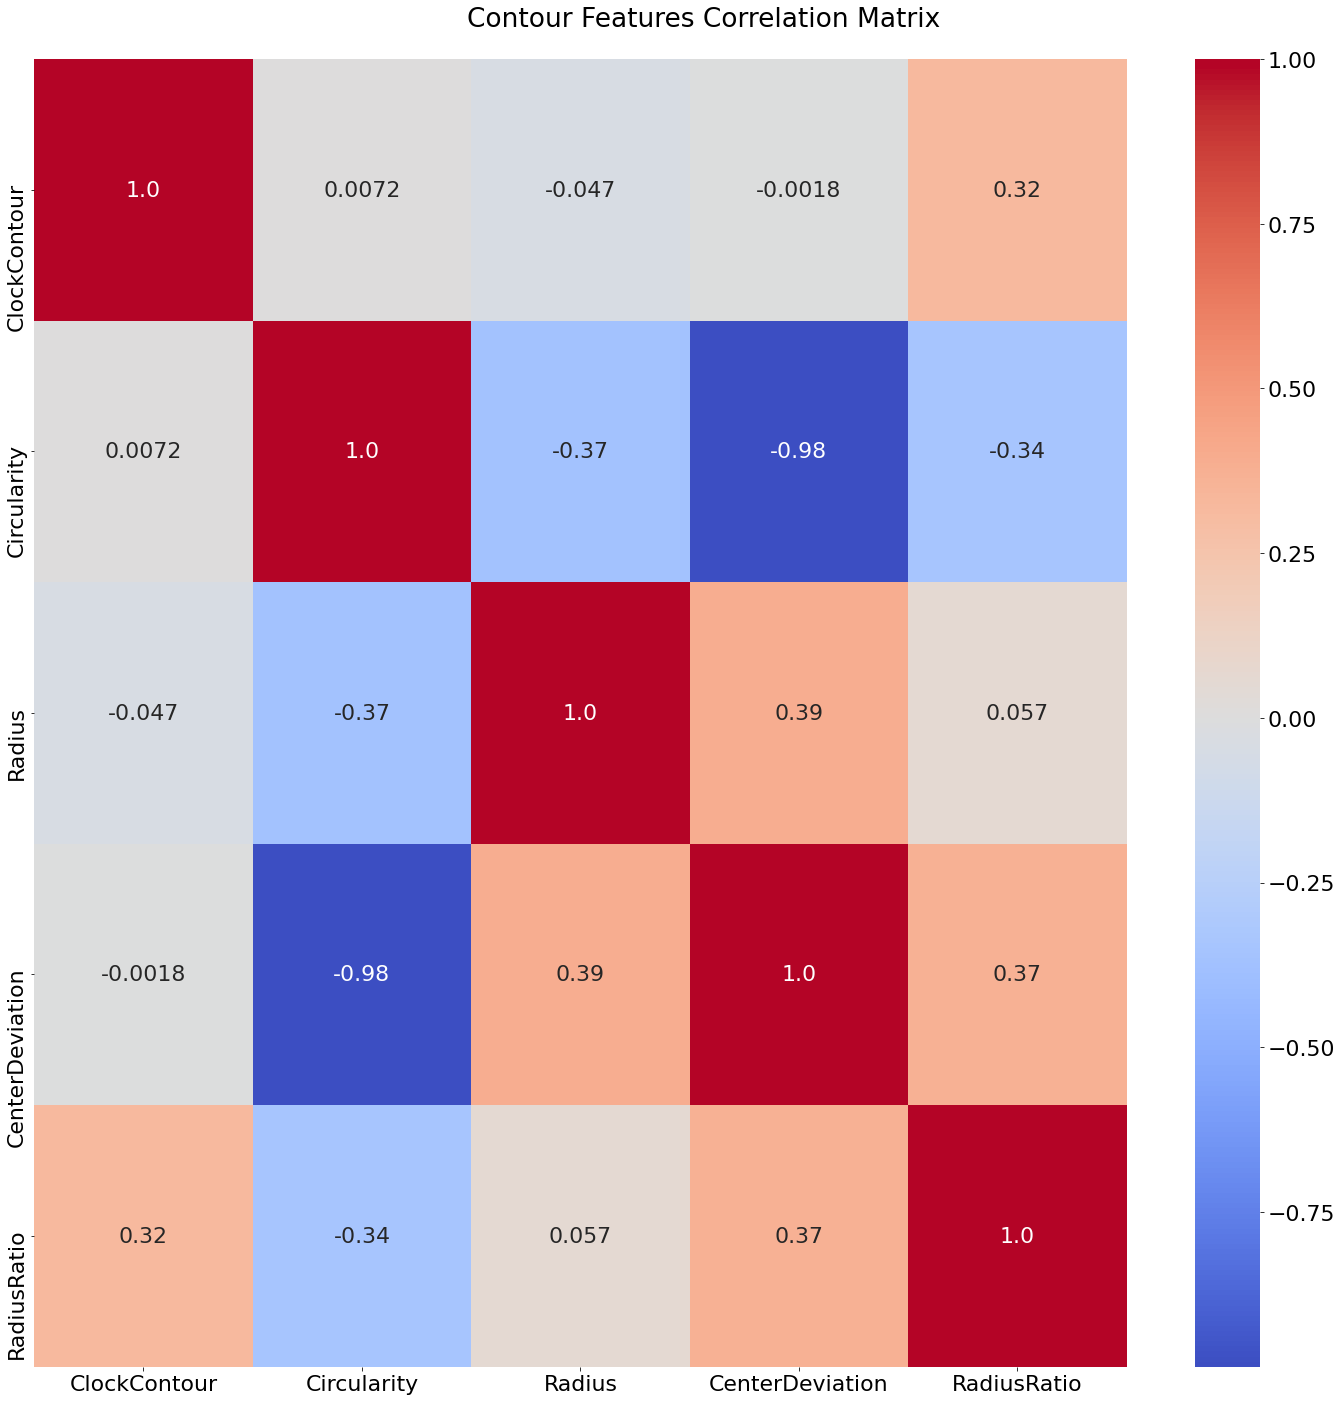

In [142]:
import seaborn
def display_pearson_heatmap():
    plt.figure(1, (20, 20))
    plt.suptitle("Contour Features Correlation Matrix")
    data = forest_df
    contours = data[['ClockContour', 'Circularity', 'Radius', 'CenterDeviation', "RadiusRatio"]]
    #hands = data[["ClockHands", 'HandsAngle', 'DensityRatio', 'BBRatio', 'LengthRatio', 'IntersectDistance', 'NumComponents']]

    seaborn.heatmap(contours.corr(), fmt='.2', cmap='coolwarm', annot=True, center=0.0)
    plt.savefig("results/contour_heatmap")
    plt.show()
    
display_pearson_heatmap()

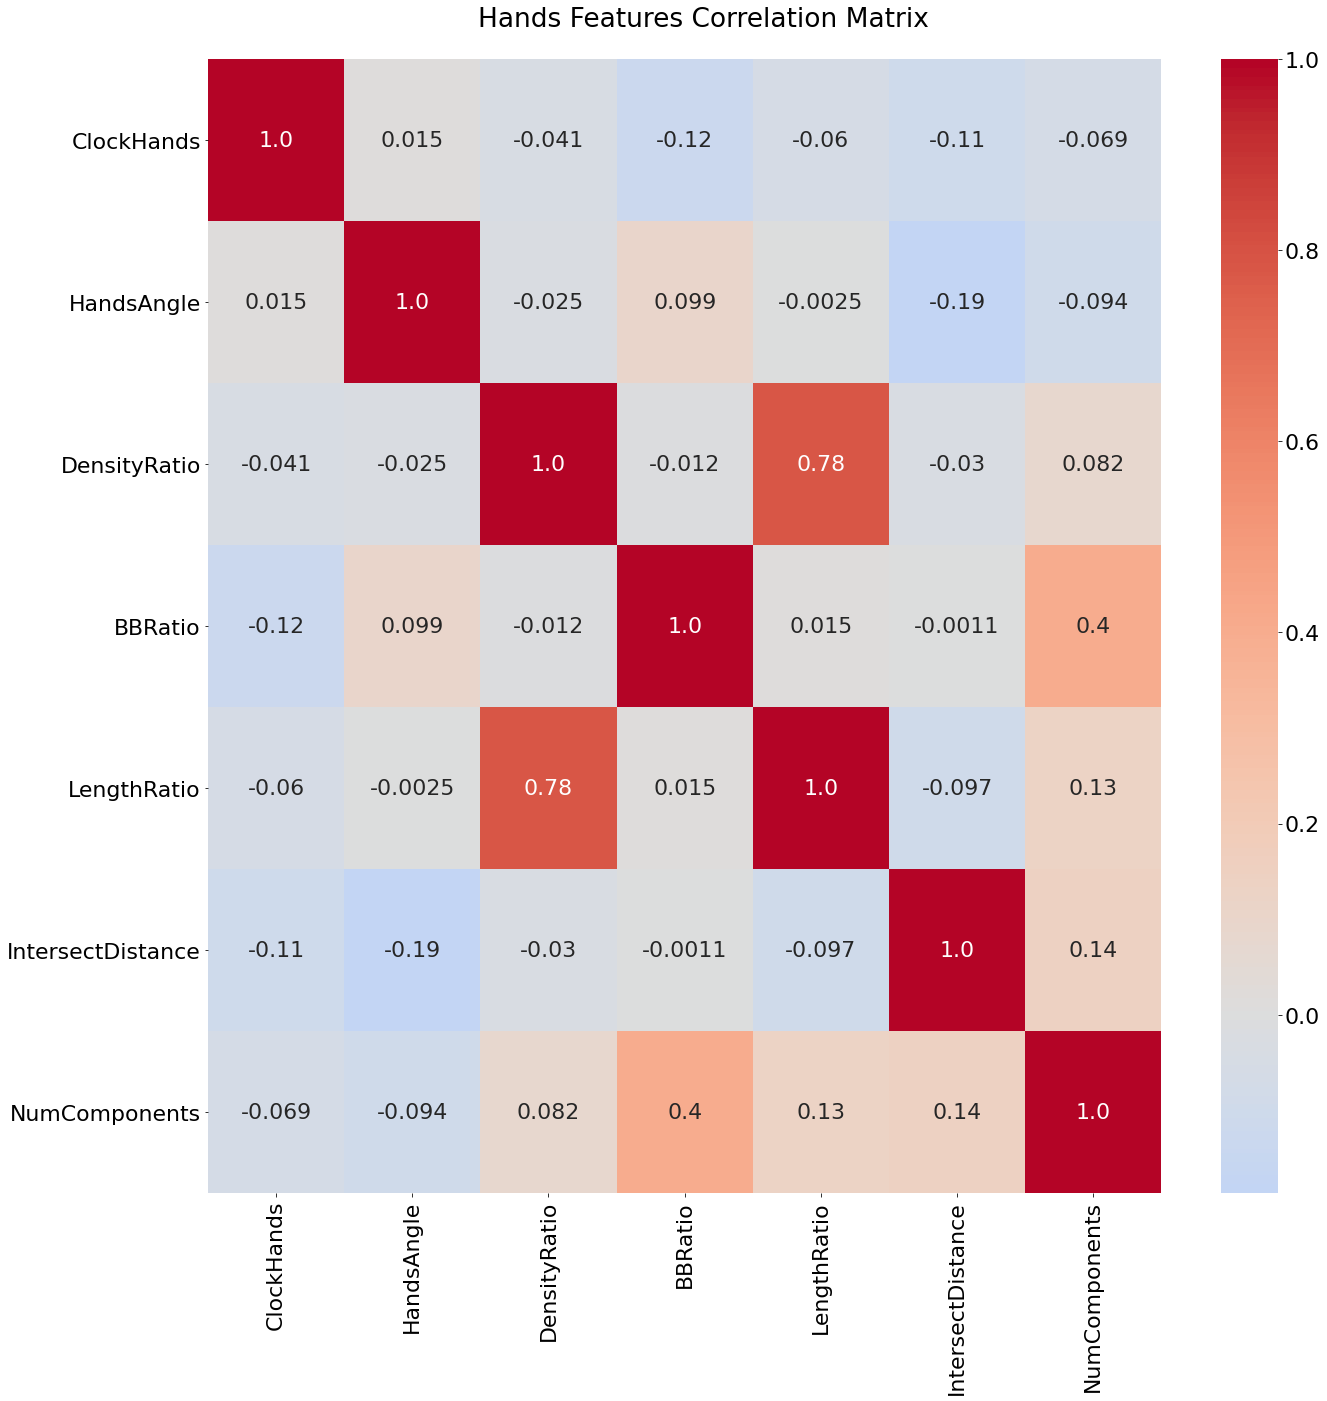

In [143]:
import seaborn
def display_pearson_heatmap():
    plt.figure(1, (20, 20))
    plt.suptitle("Hands Features Correlation Matrix")
    data = forest_df
    hands = data[["ClockHands", 'HandsAngle', 'DensityRatio', 'BBRatio', 'LengthRatio', 'IntersectDistance', 'NumComponents']]

    seaborn.heatmap(hands.corr(), fmt='.2', cmap='coolwarm', annot=True, center=0.0)
    plt.savefig("results/hands_heatmap")
    plt.show()
    
display_pearson_heatmap()

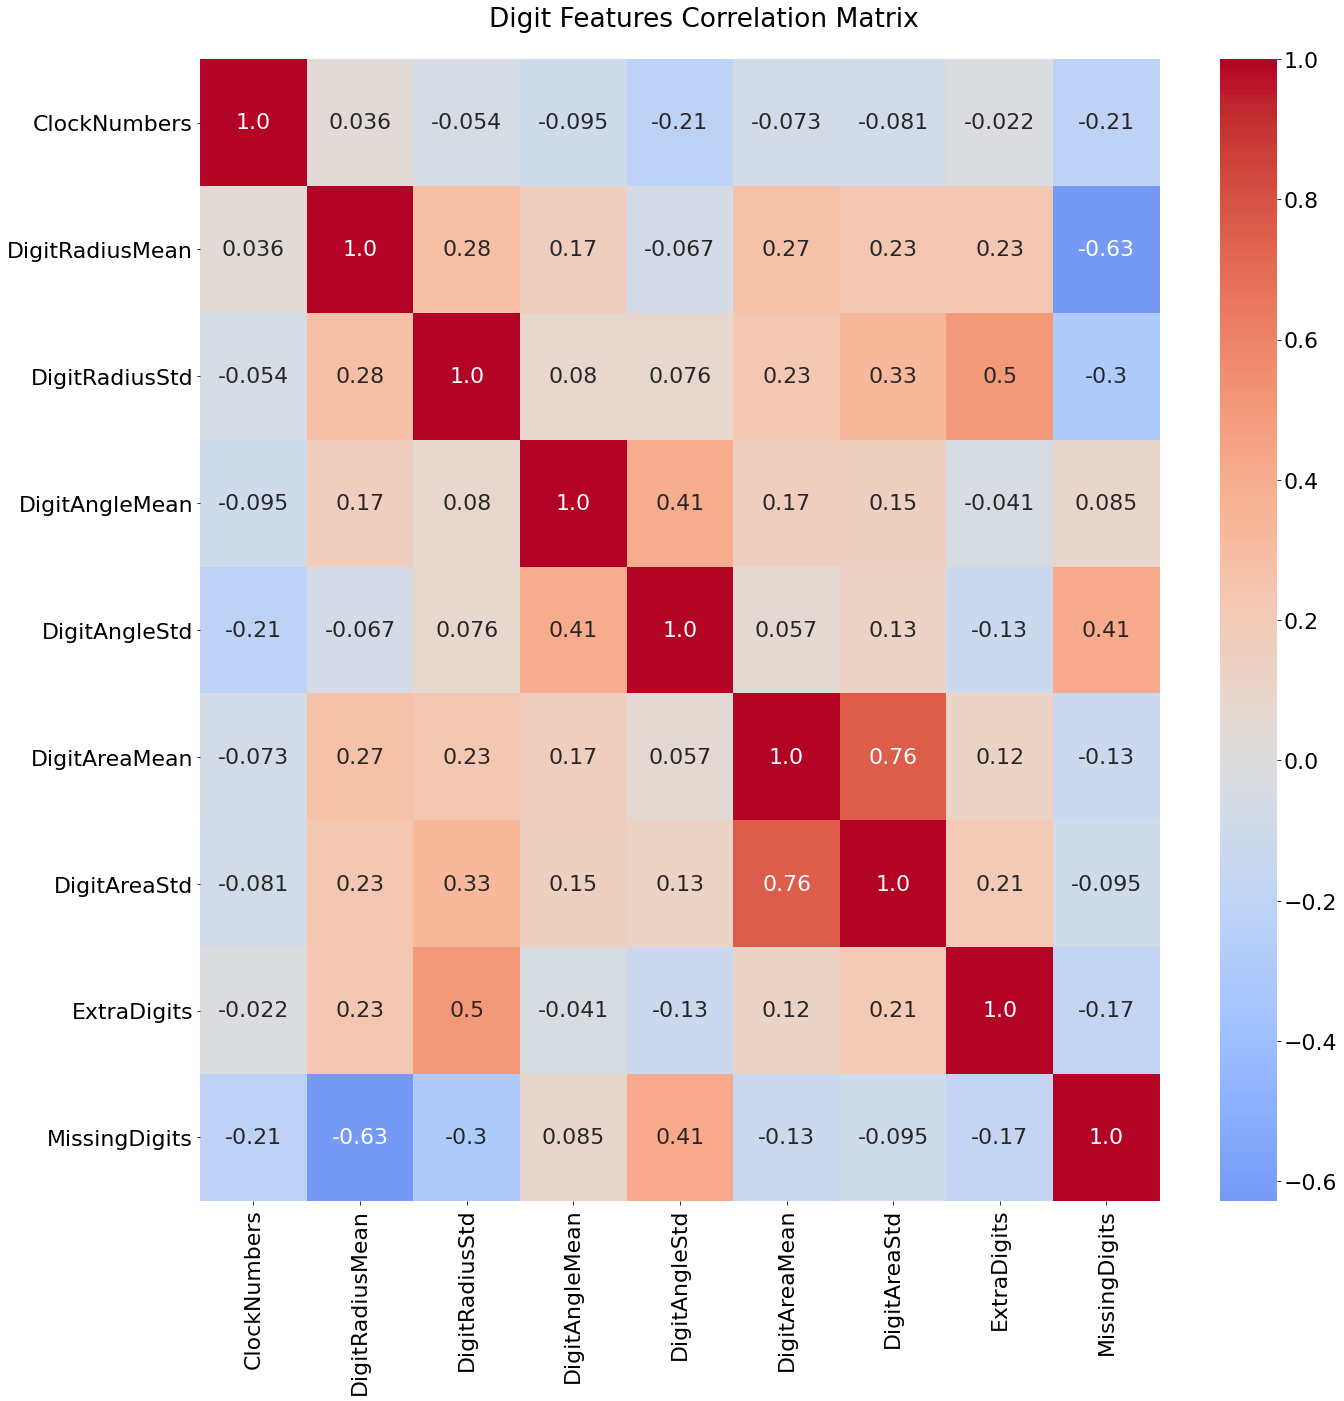

In [144]:
import seaborn
def display_pearson_heatmap():
    plt.figure(1, (20, 20))
    plt.suptitle("Digit Features Correlation Matrix")
    data = forest_df
    digits = data[["ClockNumbers", "DigitRadiusMean", "DigitRadiusStd", "DigitAngleMean", "DigitAngleStd", "DigitAreaMean", "DigitAreaStd",
               "ExtraDigits", "MissingDigits"]]

    seaborn.heatmap(digits.corr(), fmt ='.2', cmap='coolwarm', annot=True, center=0.0)
    plt.savefig("results/digits_heatmap")
    plt.show()
    
display_pearson_heatmap()

# 11. Score Correlation Table

13


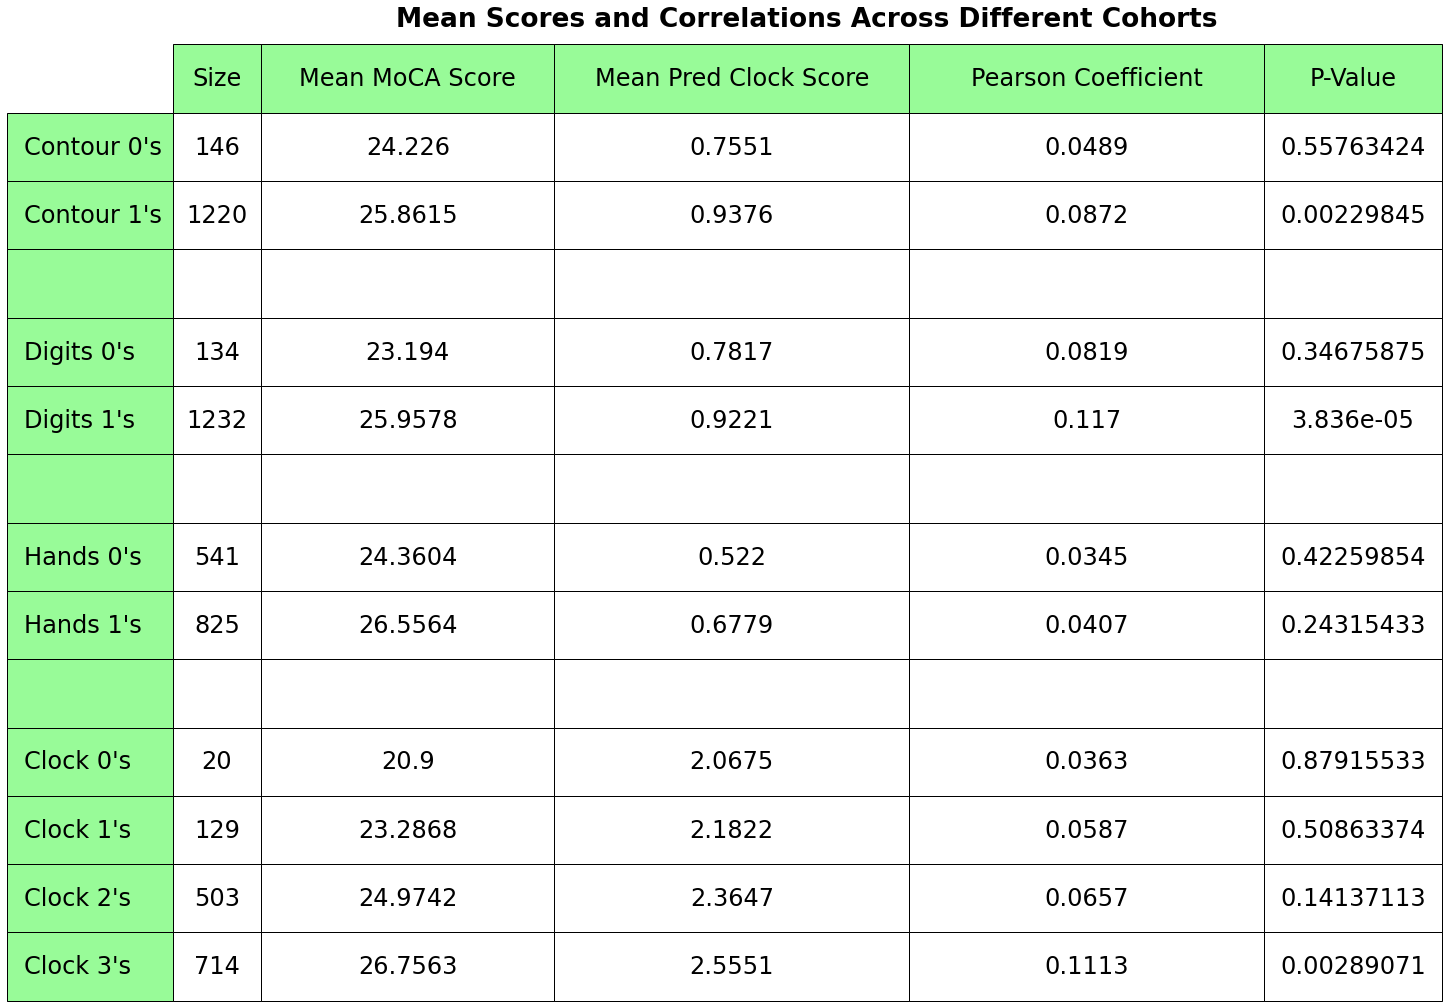

In [217]:
from scipy.stats import pearsonr

df = forest_df
table_lines = []

decimals = 4
#header = ["Num Zeros", "Pred Mean 0", "Pred Std 0", "", "Num Ones", "Pred Mean 1", "Pred Std 1"]
header = ["Size", "Mean MoCA Score", "Mean Pred Clock Score",
         "Pearson Coefficient", "P-Value"]

names = ["Contour 0's", "Contour 1's", "", "Digits 0's", "Digits 1's", "", "Hands 0's", "Hands 1's", "",
        "Clock 0's", "Clock 1's", "Clock 2's", "Clock 3's"]
predictions = ["Forest_Contour", "Forest_Contour", "Forest_Digits", "Forest_Digits",
               "Forest_Hands", "Forest_Hands", "Pred_Total", "Pred_Total", "Pred_Total", "Pred_Total"]

contour_zeros = df[df["ClockContour"] == 0]
contour_ones = df[df["ClockContour"] == 1]
digits_zeros = df[df["ClockNumbers"] == 0]
digits_ones = df[df["ClockNumbers"] == 1]
hands_zeros = df[df["ClockHands"] == 0]
hands_ones = df[df["ClockHands"] == 1]

total_zeros = df[df["Total"] == 0]
total_ones = df[df["Total"] == 1]
total_twos = df[df["Total"] == 2]
total_threes = df[df["Total"] == 3]

data_frames = [contour_zeros, contour_ones, digits_zeros, digits_ones, hands_zeros, hands_ones,
              total_zeros, total_ones, total_twos, total_threes]

for i in range(len(data_frames)):

    data = data_frames[i]
    coefficient, p = pearsonr(data["Score"], data[predictions[i]])
    table_lines.append([len(data),
                        np.round(np.mean(data["Score"]), decimals=decimals),
                        np.round(np.mean(data[predictions[i]]), decimals=decimals),
                        np.round(coefficient, decimals=decimals),
                        np.round(p, decimals=decimals*2)])
    
    if i < 7 and (i+1) % 2 == 0:
        table_lines.append(["", "", "", "", ""])
    
                       

plt.rcParams["figure.figsize"] = [21.00, 15.50]
plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots()
plt.rcParams.update({'font.size': 22})
ax.axis('tight')
ax.axis('off')
widths=[.1, .33, .4, .4, .2]
print(len(table_lines))
table = ax.table(
    cellText = table_lines,
    rowLabels = names,
    colLabels = header,
    rowColours =["palegreen"] * 13,
    colColours =["palegreen"] * 13, 
    cellLoc ='center',  
    loc ='upper center',
    colWidths=widths)

table.auto_set_font_size(False)
table.set_fontsize(24)
table.scale(1, 8)
ax.set_title('Mean Scores and Correlations Across Different Cohorts', 
             fontweight ="bold")

plt.savefig("results/score_correlations.jpg")
plt.show()